# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [13]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
from copy import deepcopy

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as colors
from cycler import cycler

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps

In [2]:
ceph_path = Path.home() / 'ceph/DATA/Chromatin/MC_condensates/'

### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 3,
    "lines.markersize": 10,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
        

# Functions

### Analytic calculations

In [4]:
def h_closure(xb,D):
    def h(t, x0):
        return aa.green_diff_fpt_dist(t, x0, xb, D)
    return h  

def approx_an_ftp_distr(t, x0, xb, D):
    h = h_closure(xb, D)
    return  h(t, x0) + h(t, -x0) - h(t,2.*xb - x0) - h(t,2.*xb + x0) - h(t, -2*xb + x0) - h(t, -2*xb -x0) + h(t,4.*xb - x0) + h(t,4.*xb + x0)

\begin{equation}
G(x,t;x_0, t_0) = \frac{1}{\sqrt{4\pi (t-t_0)}}e^{\frac{(x-x_0)^2}{4 D (t - t_0)}}
\end{equation}

\begin{equation}
P(x,t; x_0, t_0) = \sum_{n=0}^{\infty}(-1)^n \left( G(x,t;x_0-2 n x_b,t_0) + G(x,t;-x_0-2 n x_b,t_0)\right) + \sum_{n=1}^{\infty}(-1)^n \left( G(x,t;2 n x_b - x_0,t_0) + G(x,t;2 n x_b + x_0,t_0)\right)
\end{equation}

# Results/Graphs

## Single particle simulations

### Simulations

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


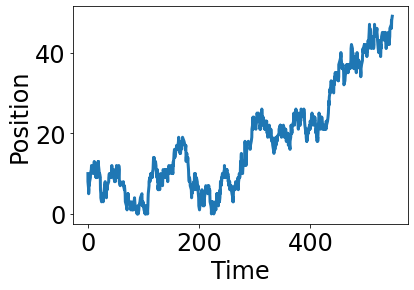

In [5]:
params = {
    'system_type': 'single_particle',
    'init_state': 10,
    'n_beads':50,
    'k_minus': 1.,
    'k_plus': 1.,
    'max_steps': -1,
    't_max': -1
}

time_arr, pos_arr = aa.run_gill_gen(rng_seed=1234, **params)
_ = plt.plot(time_arr, pos_arr)
_ = plt.xlabel('Time')
_ = plt.ylabel('Position')

In [6]:
print(max(pos_arr), min(pos_arr))
len(time_arr)

49 0


1074

In [8]:
cycles = 5000

params = {
    'system_type': 'single_particle',
    'init_state': 10,
    'k_minus': 1.,
    'k_plus': 1.,
    'max_steps': -1,
    'n_beads':50
}

time_arr_lst = []
pos_arr_lst = []
first_pass_time = []

for i in tqdm(range(1, cycles+1)):
    time_arr, pos_arr = aa.run_gill_gen(rng_seed=2*i, **params)
    #axarr[0].plot(time_arr, pos_arr, color='k', alpha=.2)
    time_arr_lst +=[time_arr]
    pos_arr_lst +=[pos_arr]
    
    first_pass_time += [time_arr[-1]] if pos_arr[-1] == params['n_beads']-1 else []

  0%|          | 0/5000 [00:00<?, ?it/s]

In [12]:
htime_arr = np.linspace(20, max(first_pass_time), 200)
h_arr = approx_an_ftp_distr(htime_arr, 10., 49., 1.)

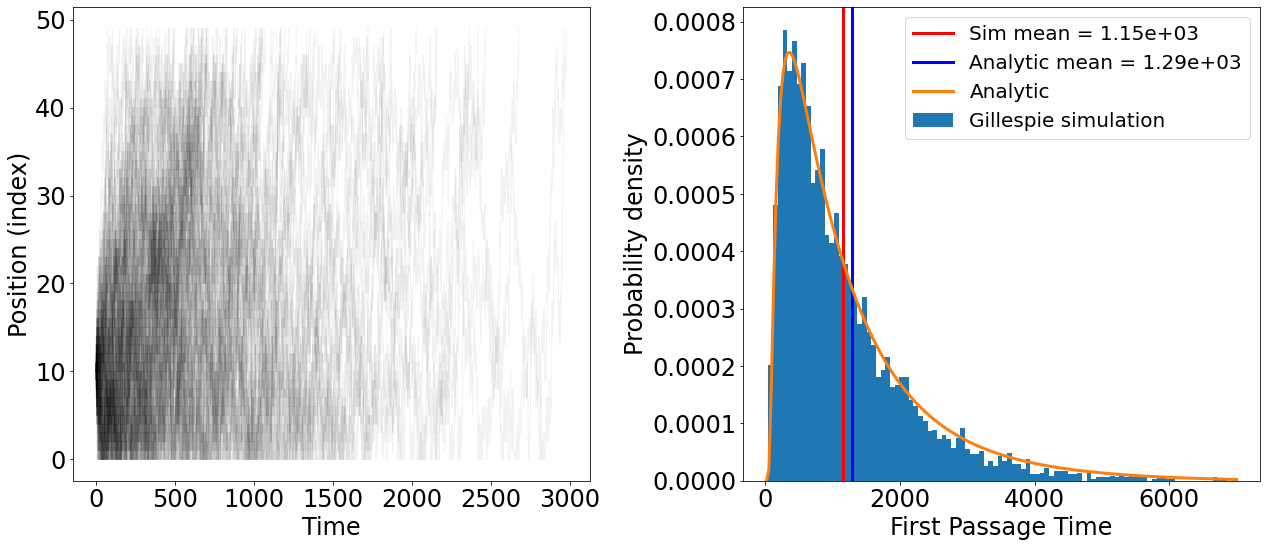

In [257]:
fig, axarr = plt.subplots(1,2, figsize=(18,8))
for time_arr, pos_arr in zip(time_arr_lst[:100], pos_arr_lst[:100]):
    _ = axarr[0].plot(time_arr, pos_arr, color='k', alpha=.05, lw=1)

# Simulation plotting
_ = axarr[1].hist(first_pass_time, density=True, bins=100, label = 'Gillespie simulation')
_ = axarr[1].axvline(np.mean(first_pass_time), color='r', label=f'Sim mean = {np.mean(first_pass_time):.3g}')
# Analytic plotting
_ = axarr[1].axvline(an_mean, color='b', label=f'Analytic mean = {an_mean:.3g}')
_ = axarr[1].plot(htime_arr, h_arr, label= "Analytic") 
_ = axarr[0].set_xlabel('Time')
_ = axarr[1].set_xlabel('First Passage Time')
_ = axarr[0].set_ylabel('Position (index)')
_ = axarr[1].set_ylabel('Probability density')
#_ = axarr[1].set_title('First passage time')
_ = axarr[1].legend()
fig.tight_layout()

In [36]:
cycles = 5000

params = {
    'system_type': 'single_particle',
    'init_state': 10,
    'k_minus': 5.,
    'k_plus': 5.,
    'max_steps': -1,
    'n_beads':50
}

time_arr_lst = []
pos_arr_lst = []
first_pass_time = []

for i in tqdm(range(1, cycles+1)):
    time_arr, pos_arr = aa.run_gill_gen(rng_seed=2*i, **params)
    #axarr[0].plot(time_arr, pos_arr, color='k', alpha=.2)
    time_arr_lst +=[time_arr]
    pos_arr_lst +=[pos_arr]
    
    first_pass_time += [time_arr[-1]] if pos_arr[-1] == params['n_beads']-1 else []

  0%|          | 0/5000 [00:00<?, ?it/s]

In [51]:
htime_arr = np.linspace(20, max(first_pass_time), 1000)
h_arr = approx_an_ftp_distr(htime_arr, 10., 49., 5)
an_mean = (htime_arr*h_arr).sum()*((max(first_pass_time)-20))/1000

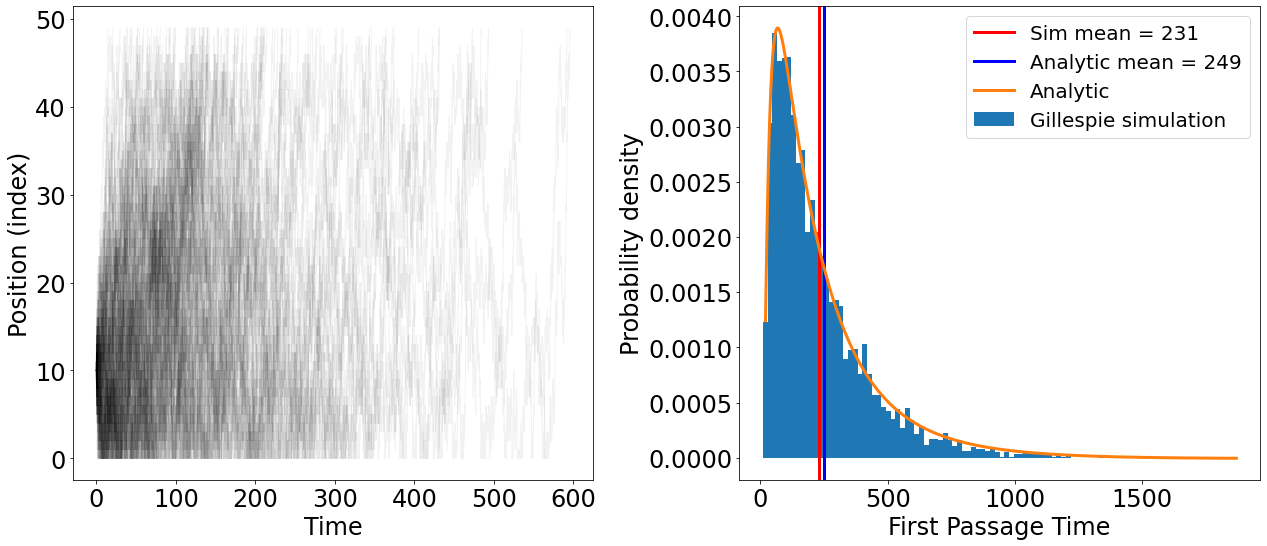

In [52]:
fig, axarr = plt.subplots(1,2, figsize=(18,8))
for time_arr, pos_arr in zip(time_arr_lst[:100], pos_arr_lst[:100]):
    _ = axarr[0].plot(time_arr, pos_arr, color='k', alpha=.05, lw=1)

# Simulation plotting
_ = axarr[1].hist(first_pass_time, density=True, bins=100, label = 'Gillespie simulation')
_ = axarr[1].axvline(np.mean(first_pass_time), color='r', label=f'Sim mean = {np.mean(first_pass_time):.3g}')
# Analytic plotting
_ = axarr[1].axvline(an_mean, color='b', label=f'Analytic mean = {an_mean:.3g}')
_ = axarr[1].plot(htime_arr, h_arr, label= "Analytic") 
_ = axarr[0].set_xlabel('Time')
_ = axarr[1].set_xlabel('First Passage Time')
_ = axarr[0].set_ylabel('Position (index)')
_ = axarr[1].set_ylabel('Probability density')
#_ = axarr[1].set_title('First passage time')
_ = axarr[1].legend()
fig.tight_layout()

### Modified boundary conditions

In [2]:
cycles = 20000

params = {
    'system_type': 'single_particle',
    'init_state': 10,
    'k_minus': 1.,
    'k_plus': 1.,
    'max_steps': -1,
    'n_beads':50
}

time_arr_lst = []
pos_arr_lst = []
first_pass_time = []

for i in tqdm(range(1, cycles+1)):
    time_arr, pos_arr = aa.run_gill_gen(rng_seed=2*i, **params)
    #axarr[0].plot(time_arr, pos_arr, color='k', alpha=.2)
    time_arr_lst +=[time_arr]
    pos_arr_lst +=[pos_arr]
    
    first_pass_time += [time_arr[-1]] if pos_arr[-1] == params['n_beads']-1 else []

  0%|          | 0/20000 [00:00<?, ?it/s]

In [53]:
print((htime_arr*h_arr).sum()*(max(first_pass_time)-20)/200)
an_mean = (htime_arr*h_arr).sum()*(max(first_pass_time)-20)/200.

1246.3603604727468


In [12]:
htime_arr = np.linspace(20, max(first_pass_time), 200)
h_arr = approx_an_ftp_distr(htime_arr, 10., 49., 1.)

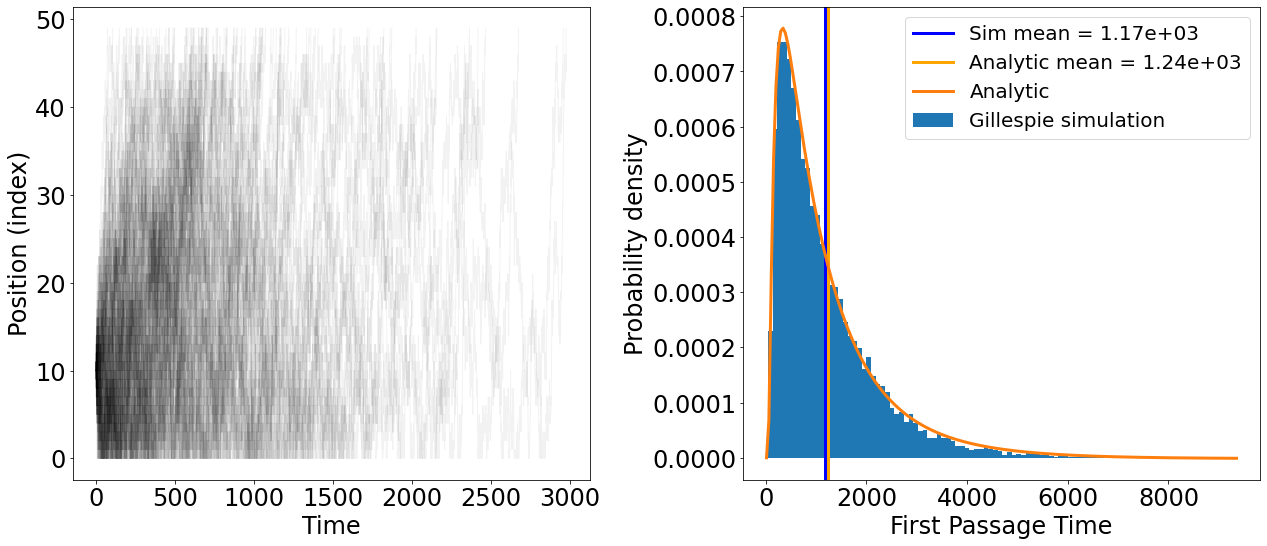

In [14]:
fig, axarr = plt.subplots(1,2, figsize=(18,8))
for time_arr, pos_arr in zip(time_arr_lst[:100], pos_arr_lst[:100]):
    _ = axarr[0].plot(time_arr, pos_arr, color='k', alpha=.05, lw=1)

# Simulation plotting
_ = axarr[1].hist(first_pass_time, density=True, bins=100, label = 'Gillespie simulation')
_ = axarr[1].axvline(np.mean(first_pass_time), color='b', label=f'Sim mean = {np.mean(first_pass_time):.3g}')
# Analytic plotting
_ = axarr[1].axvline(an_mean, color='orange', label=f'Analytic mean = {an_mean:.3g}')
_ = axarr[1].plot(htime_arr, h_arr, label= "Analytic") 
_ = axarr[0].set_xlabel('Time')
_ = axarr[1].set_xlabel('First Passage Time')
_ = axarr[0].set_ylabel('Position (index)')
_ = axarr[1].set_ylabel('Probability density')
#_ = axarr[1].set_title('First passage time')
_ = axarr[1].legend()
fig.tight_layout()

The doubly bound off rate is 3.05/sec so we are looking at a mean passage time of around 383 seconds. This assumes that unbinding is the rate limiting step which I am assuming because condensates are unlikely to be stable if the on rate is less than the off rate. There is no force- or energy-dependent unbinding.

## Two particle simulations

In [55]:
p2_params = {
    'rng_seed': 1234,
    'n_beads' : 100, 
    'max_steps': 10000,
    'init_state':[10,90],
    'system_type': 'two_particle',
    'kinetics': {
        'func': 'const',
        'k0': [1.,1.],
        'k1': [1.,1.],
    }
}

In [56]:
time_arr, state_arr = aa.run_gill_gen(**p2_params)

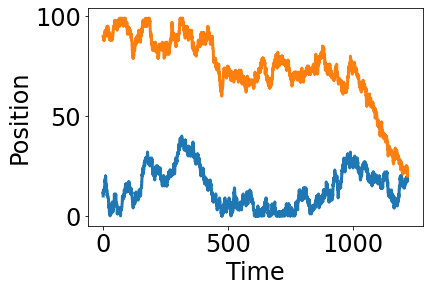

In [57]:
_ = plt.plot(time_arr, state_arr)
_ = plt.xlabel('Time')
_ = plt.ylabel('Position')

In [9]:
cycles = 10000

p2_params = {
    'n_beads' : 100, 
    'max_steps': -1,
    'init_state':[10,90],
    'system_type': 'two_particle',
    'kinetics': {
        'func': 'const',
        'k0': [1.,1.],
        'k1': [1.,1.],
    }
}

tp_time_arr_lst = []
tp_state_arr_lst = []
tp_first_pass_time = []

for i in tqdm(range(1, cycles+1)):
    time_arr, state_arr = aa.run_gill_gen(rng_seed=2*i, **p2_params)
    tp_time_arr_lst += [time_arr]
    tp_state_arr_lst += [state_arr]
    
    tp_first_pass_time += [time_arr[-1]] if state_arr[-1,0] == state_arr[-1,1] else []
print(len(tp_first_pass_time))

  0%|          | 0/10000 [00:00<?, ?it/s]

10000


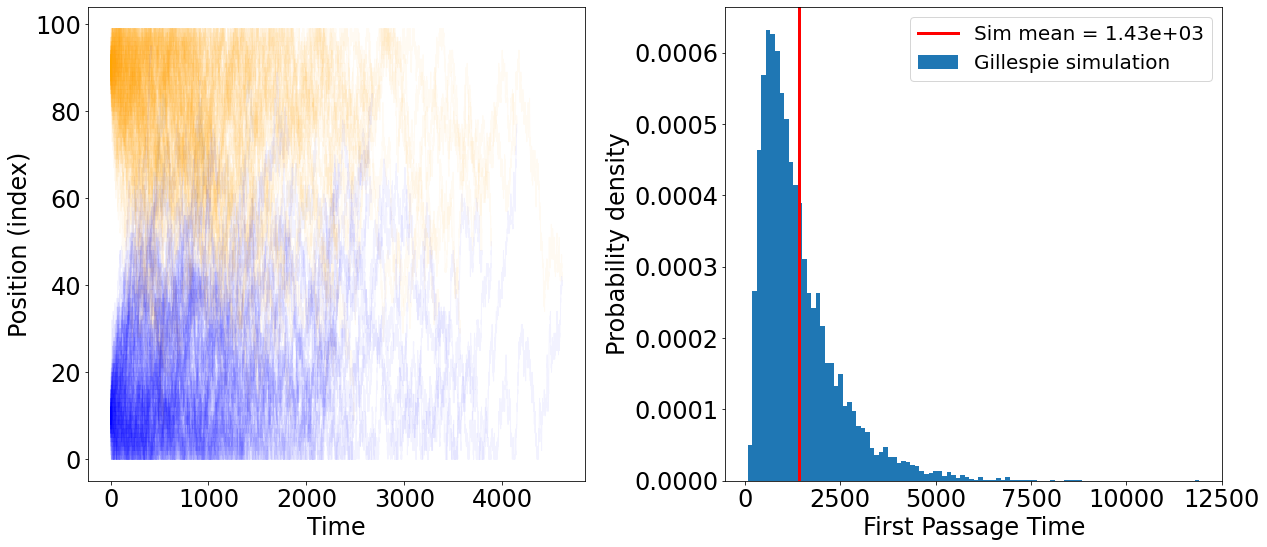

In [11]:
fig, axarr = plt.subplots(1,2, figsize=(18,8))
for time_arr, pos_arr in zip(tp_time_arr_lst[:100], tp_state_arr_lst[:100]):
    _ = axarr[0].plot(time_arr, pos_arr[:,0], color='b', alpha=.05, lw=1)
    _ = axarr[0].plot(time_arr, pos_arr[:,1], color='orange', alpha=.05, lw=1)

# Simulation plotting
_ = axarr[1].hist(tp_first_pass_time, density=True, bins=100, label = 'Gillespie simulation')
_ = axarr[1].axvline(np.mean(tp_first_pass_time), color='r', label=f'Sim mean = {np.mean(tp_first_pass_time):.3g}')

_ = axarr[0].set_xlabel('Time')
_ = axarr[1].set_xlabel('First Passage Time')
_ = axarr[0].set_ylabel('Position (index)')
_ = axarr[1].set_ylabel('Probability density')

_ = axarr[1].legend()
fig.tight_layout()

In [4]:
# Start closer together
cycles = 10000

p2_params = {
    'n_beads' : 100, 
    'max_steps': -1,
    'init_state':[30,0],
    'system_type': 'two_particle',
    'kinetics': {
        'func': 'const',
        'k0': [1.,1.],
        'k1': [1.,1.],
    }
}

tp2_time_arr_lst = []
tp2_state_arr_lst = []
tp2_first_pass_time = []

for i in tqdm(range(1, cycles+1)):
    time_arr, state_arr = aa.run_gill_two_part_diffuse(rng_seed=2*i, **p2_params)
    tp2_time_arr_lst += [time_arr]
    tp2_state_arr_lst += [state_arr]
    
    tp2_first_pass_time += [time_arr[-1]] if state_arr[-1,0] == state_arr[-1,1] else []
print(len(tp2_first_pass_time))

  0%|          | 0/10000 [00:00<?, ?it/s]

AttributeError: module 'alens_analysis' has no attribute 'run_gill_two_part_diffuse'

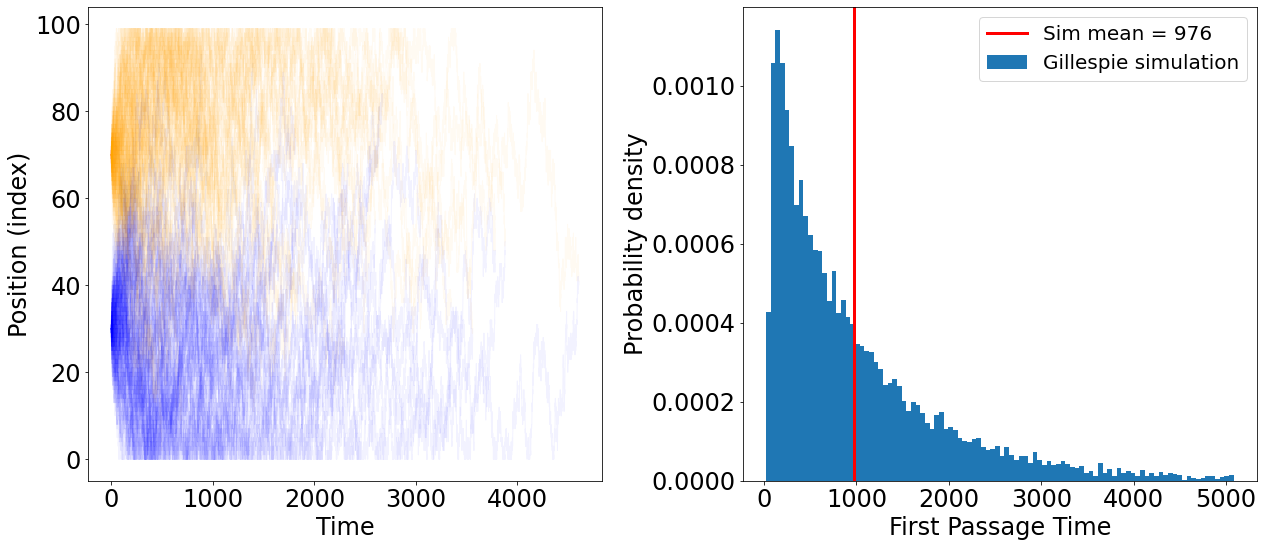

In [200]:
fig, axarr = plt.subplots(1,2, figsize=(18,8))
for time_arr, pos_arr in zip(tp2_time_arr_lst[:100], tp2_state_arr_lst[:100]):
    _ = axarr[0].plot(time_arr, pos_arr[:,0], color='b', alpha=.05, lw=1)
    _ = axarr[0].plot(time_arr, pos_arr[:,1], color='orange', alpha=.05, lw=1)

# Simulation plotting
_ = axarr[1].hist(tp2_first_pass_time, density=True, bins=100, label = 'Gillespie simulation')
_ = axarr[1].axvline(np.mean(tp2_first_pass_time), color='r', label=f'Sim mean = {np.mean(tp2_first_pass_time):.3g}')
# Analytic plotting
#_ = axarr[1].axvline(an_mean, color='b', label=f'Analytic mean = {an_mean:.3g}')
#_ = axarr[1].plot(htime_arr, h_arr, label= "Analytic") 
_ = axarr[0].set_xlabel('Time')
_ = axarr[1].set_xlabel('First Passage Time')
_ = axarr[0].set_ylabel('Position (index)')
_ = axarr[1].set_ylabel('Probability density')

_ = axarr[1].legend()
#_ = axarr[1].set_yscale('log')
fig.tight_layout()

In [191]:
cycles = 5000

p2_params = {
    'n_beads' : 100, 
    'max_steps': 20000,
    'init_pos0': 10,
    'init_pos1': 90,
    'kinetics': {
        'func': 'const',
        'k0': [2.,2.],
        'k1': [1.,1.],
    }
}

tp2b_time_arr_lst = []
tp2b_state_arr_lst = []
tp2b_first_pass_time = []

for i in tqdm(range(1, cycles+1)):
    time_arr, state_arr = aa.run_gill_two_part_diffuse(rng_seed=2*i, **p2_params)
    tp2b_time_arr_lst += [time_arr]
    tp2b_state_arr_lst += [state_arr]
    
    tp2b_first_pass_time += [time_arr[-1]] if state_arr[-1,0] == state_arr[-1,1] else []

  0%|          | 0/5000 [00:00<?, ?it/s]

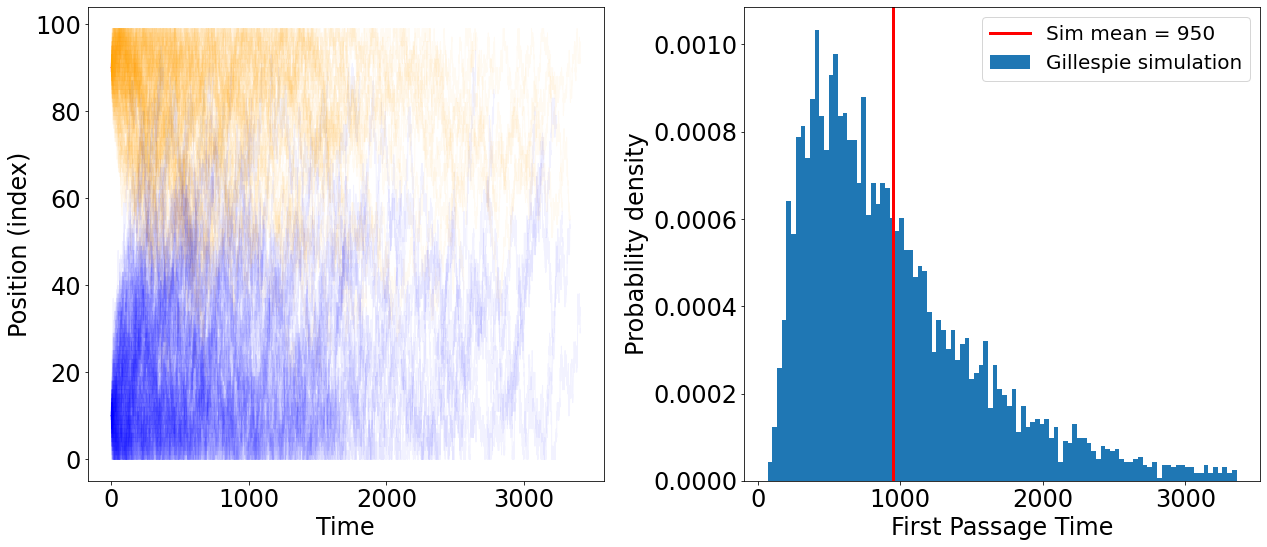

In [193]:
fig, axarr = plt.subplots(1,2, figsize=(18,8))
for time_arr, pos_arr in zip(tp2b_time_arr_lst[:100], tp2b_state_arr_lst[:100]):
    _ = axarr[0].plot(time_arr, pos_arr[:,0], color='b', alpha=.05, lw=1)
    _ = axarr[0].plot(time_arr, pos_arr[:,1], color='orange', alpha=.05, lw=1)

# Simulation plotting
_ = axarr[1].hist(tp2b_first_pass_time, density=True, bins=100, label = 'Gillespie simulation')
_ = axarr[1].axvline(np.mean(tp2_first_pass_time), color='r', label=f'Sim mean = {np.mean(tp2b_first_pass_time):.3g}')
# Analytic plotting
#_ = axarr[1].axvline(an_mean, color='b', label=f'Analytic mean = {an_mean:.3g}')
#_ = axarr[1].plot(htime_arr, h_arr, label= "Analytic") 
_ = axarr[0].set_xlabel('Time')
_ = axarr[1].set_xlabel('First Passage Time')
_ = axarr[0].set_ylabel('Position (index)')
_ = axarr[1].set_ylabel('Probability density')

_ = axarr[1].legend()
#_ = axarr[1].set_yscale('log')
fig.tight_layout()

In [205]:
cycles = 5000

p2_params = {
    'n_beads' : 100, 
    'max_steps': 20000,
    'init_pos0': 30,
    'init_pos1': 70,
    'kinetics': {
        'func': 'const',
        'k0': [2.,2.],
        'k1': [1.,1.],
    }
}

tp3b_time_arr_lst = []
tp3b_state_arr_lst = []
tp3b_first_pass_time = []

for i in tqdm(range(1, cycles+1)):
    time_arr, state_arr = aa.run_gill_two_part_diffuse(rng_seed=2*i, **p2_params)
    tp3b_time_arr_lst += [time_arr]
    tp3b_state_arr_lst += [state_arr]
    
    tp3b_first_pass_time += [time_arr[-1]] if state_arr[-1,0] == state_arr[-1,1] else []

  0%|          | 0/5000 [00:00<?, ?it/s]

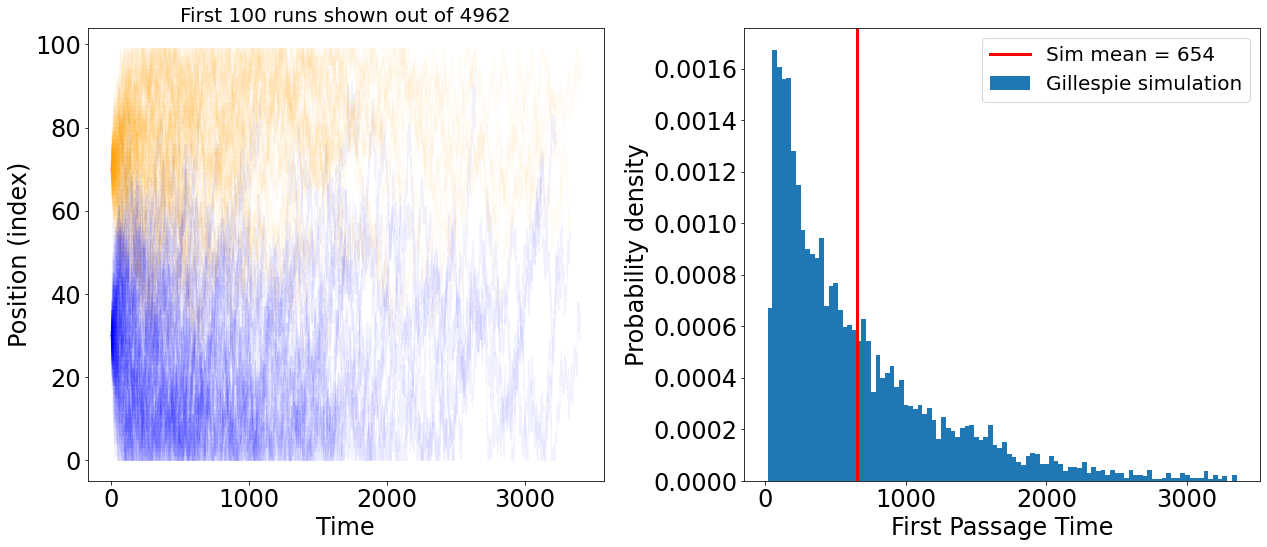

In [209]:
fig, axarr = plt.subplots(1,2, figsize=(18,8))
n_graph_runs = 100
# A little name bashing
tmp_time_arr, tmp_state_arr, tmp_fpt = (tp3b_time_arr_lst, tp3b_state_arr_lst, tp3b_first_pass_time)
for time_arr, pos_arr in zip(tmp_time_arr[:n_graph_runs], tmp_state_arr[:n_graph_runs]):
    _ = axarr[0].plot(time_arr, pos_arr[:,0], color='b', alpha=.05, lw=1)
    _ = axarr[0].plot(time_arr, pos_arr[:,1], color='orange', alpha=.05, lw=1)

# Simulation plotting
_ = axarr[1].hist(tmp_fpt, density=True, bins=100, label = 'Gillespie simulation')
_ = axarr[1].axvline(np.mean(tmp_fpt), color='r', label=f'Sim mean = {np.mean(tmp_fpt):.3g}')
# Analytic plotting
#_ = axarr[1].axvline(an_mean, color='b', label=f'Analytic mean = {an_mean:.3g}')
_ = axarr[0].set_title(f'First {n_graph_runs} runs shown out of {len(tmp_fpt)}')
#_ = axarr[1].plot(htime_arr, h_arr, label= "Analytic") 
_ = axarr[0].set_xlabel('Time')
_ = axarr[1].set_xlabel('First Passage Time')
_ = axarr[0].set_ylabel('Position (index)')
_ = axarr[1].set_ylabel('Probability density')

_ = axarr[1].legend()
#_ = axarr[1].set_yscale('log')
fig.tight_layout()

## One blob simulations

In [218]:
g1_params = {
    'system': 'single_blob',
    'n_beads' : 200, 
    'max_steps': 20000,
    'init_state': [75,125],
    'kinetics': {
        'func': 'const',
        'min_beads': 100,
        'kon': [1.5,1.5],
        'koff': [1.,1.]
    }
}

time_arr, state_arr = aa.run_gill_gen(rng_seed=1234, **g1_params)
mid_point_arr = state_arr.mean(axis=-1)

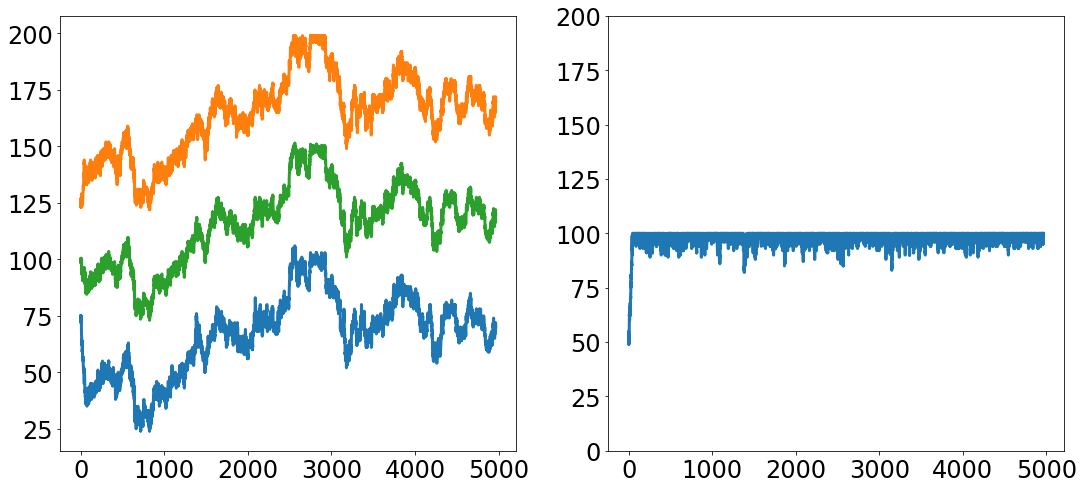

In [225]:
fig, axarr = plt.subplots(1,2, figsize=(18,8))
_ = axarr[0].plot(time_arr, state_arr)
_ = axarr[0].plot(time_arr, mid_point_arr)
_ = axarr[1].plot(time_arr, np.diff(state_arr, axis=-1))
_ = axarr[1].set_ylim(0, 200)


In [271]:
g1_params = {
    'system_type': 'single_blob',
    'n_beads' : 200, 
    'max_steps': 20000,
    'init_state': [75,125],
    'kinetics': {
        'func': 'const',
        'min_beads': 100,
        'kon': [1.,1.],
        'koff': [1.,1.]
    }
}

time_arr, state_arr = aa.run_gill_gen(rng_seed=1234, **g1_params)
mid_point_arr = state_arr.mean(axis=-1)

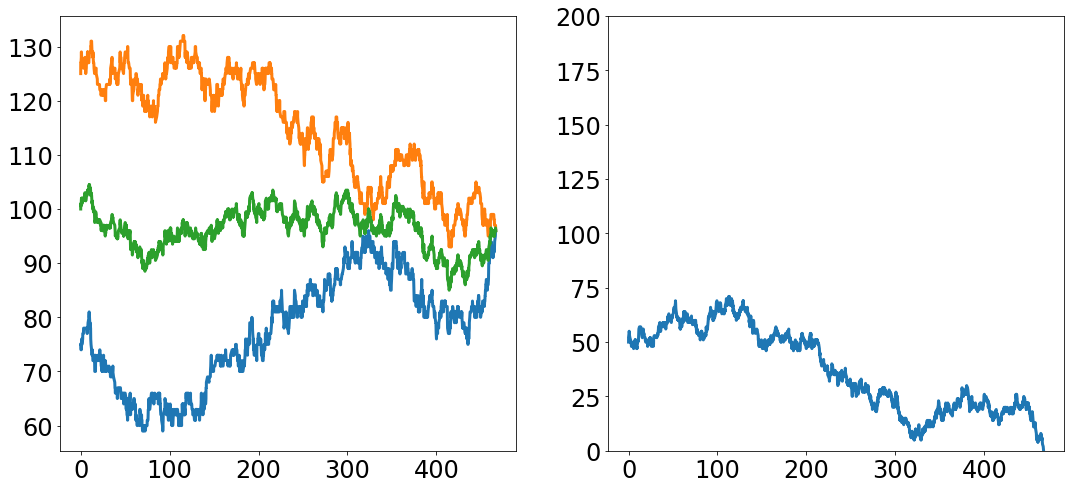

In [272]:
fig, axarr = plt.subplots(1,2, figsize=(18,8))
_ = axarr[0].plot(time_arr, state_arr)
_ = axarr[0].plot(time_arr, mid_point_arr)
_ = axarr[1].plot(time_arr, np.diff(state_arr, axis=-1))
_ = axarr[1].set_ylim(0, 200)


In [278]:
avg_time_arr = np.linspace(0,max(time_arr), 2*time_arr.size+1)
avg_mp_arr = np.interp(avg_time_arr, time_arr, mid_point_arr) 

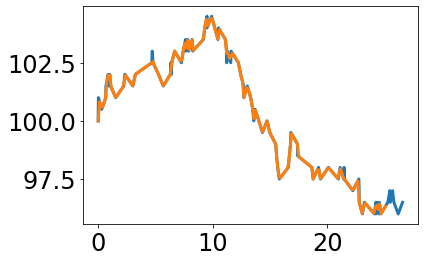

In [280]:
plt.plot(time_arr[:100], mid_point_arr[:100])
plt.plot(avg_time_arr[:200], avg_mp_arr[:200])

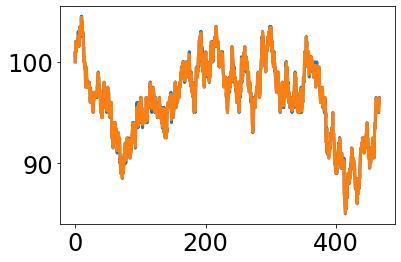

In [281]:
plt.plot(time_arr, mid_point_arr)
plt.plot(avg_time_arr, avg_mp_arr)

In [230]:
cycles = 5000

g1_params = {
    'system': 'single_blob',
    'n_beads' : 200, 
    'max_steps': 20000,
    'init_state': [75,125],
    'kinetics': {
        'func': 'const',
        'min_beads': 100,
        'kon': [1.,1.],
        'koff': [1.,1.]
    }
}

g1_k1_time_arr_lst = []
g1_k1_state_arr_lst = []
g1_k1_first_pass_time = []
g1_k1_size_arr_lst = []

for i in tqdm(range(1, cycles+1)):
    time_arr, state_arr = aa.run_gill_gen(rng_seed=2*i, **g1_params)
    g1_k1_time_arr_lst += [time_arr]
    g1_k1_state_arr_lst += [state_arr]
    g1_k1_size_arr_lst += [np.diff(state_arr, axis=-1)]
    g1_k1_com_arr_lst += [state_arr.mean(axis=-1)]
    

g1_k1_time_arr_lst = []
g1_k1_state_arr_lst = []
g1_k1_first_pass_time = []
g1_k1_size_arr_lst = []

  0%|          | 0/5000 [00:00<?, ?it/s]

In [231]:
g1_k1_size_arr_lst = [np.diff(state_arr, axis=-1) for state_arr in g1_k1_state_arr_lst]
g1_k1_com_arr_lst = [state_arr.mean(axis=-1) for state_arr in g1_k1_state_arr_lst]

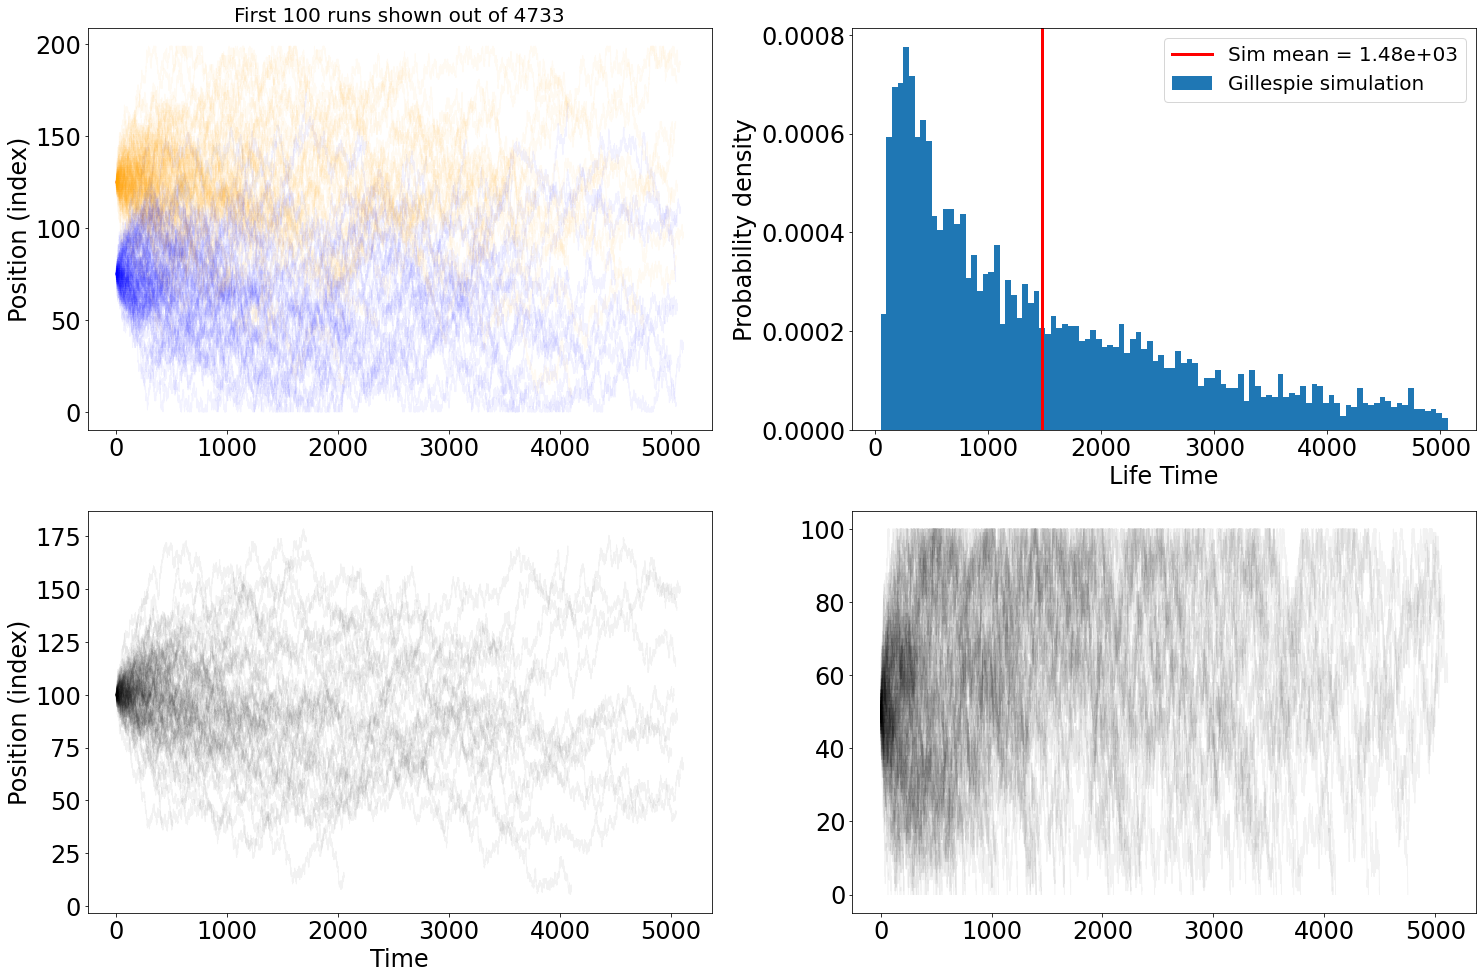

In [234]:
fig, axarr = plt.subplots(2,2, figsize=(21,14))
n_graph_runs = 100
# A little name bashing
tmp_time_arr, tmp_state_arr, tmp_fpt = (g1_k1_time_arr_lst, g1_k1_state_arr_lst, g1_k1_first_pass_time)

for time_arr, pos_arr, com_arr, size_arr in zip(tmp_time_arr[:n_graph_runs], tmp_state_arr[:n_graph_runs],g1_k1_com_arr_lst[:n_graph_runs], g1_k1_size_arr_lst[:n_graph_runs]):
    _ = axarr[0][0].plot(time_arr, pos_arr[:,0], color='b', alpha=.05, lw=1)
    _ = axarr[0][0].plot(time_arr, pos_arr[:,1], color='orange', alpha=.05, lw=1)
    _ = axarr[1][0].plot(time_arr, com_arr, color='k',alpha=.05, lw=1)
    _ = axarr[1][1].plot(time_arr, size_arr, color='k',alpha=.05, lw=1)

# Simulation plotting
_ = axarr[0,1].hist(tmp_fpt, density=True, bins=100, label = 'Gillespie simulation')
_ = axarr[0,1].axvline(np.mean(tmp_fpt), color='r', label=f'Sim mean = {np.mean(tmp_fpt):.3g}')
# Analytic plotting
#_ = axarr[1].axvline(an_mean, color='b', label=f'Analytic mean = {an_mean:.3g}')
_ = axarr[0,0].set_title(f'First {n_graph_runs} runs shown out of {len(tmp_fpt)}')
#_ = axarr[1].plot(htime_arr, h_arr, label= "Analytic") 
_ = axarr[1,0].set_xlabel('Time')
_ = axarr[0,1].set_xlabel('Life Time')
_ = axarr[0,0].set_ylabel('Position (index)')
_ = axarr[1,0].set_ylabel('COM Position (index)')
_ = axarr[0,1].set_ylabel('Probability density')

_ = axarr[0,1].legend()
#_ = axarr[1].set_yscale('log')
fig.tight_layout()

In [25]:
cycles = 20000

g1_params = {
    'system_type': 'single_blob',
    'n_beads' : 200, 
    'max_steps': -1,
    'init_state': [75,125],
    'kinetics': {
        'func': 'const',
        'min_beads': 100,
        'kon': [1.,1.],
        'koff': [1.2,1.2]
    }
}
data_dict = { 'params': g1_params,
              'time': [],
              'state': [],
              'com' : [],
              'fpt' : [],
              'size' : [],
                  }



for i in tqdm(range(1, cycles+1)):
    time_arr, state_arr = aa.run_gill_gen(rng_seed=2*i, **g1_params)
    data_dict['time'] += [time_arr]
    data_dict['state'] += [state_arr]
    data_dict['size'] += [np.diff(state_arr, axis=-1)]
    data_dict['com'] += [state_arr.mean(axis=-1)]
    data_dict['fpt'] += [time_arr[-1]] if state_arr[-1,0] == state_arr[-1,1] else []

g1_koff11_dict = deepcopy(data_dict)


  0%|          | 0/20000 [00:00<?, ?it/s]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


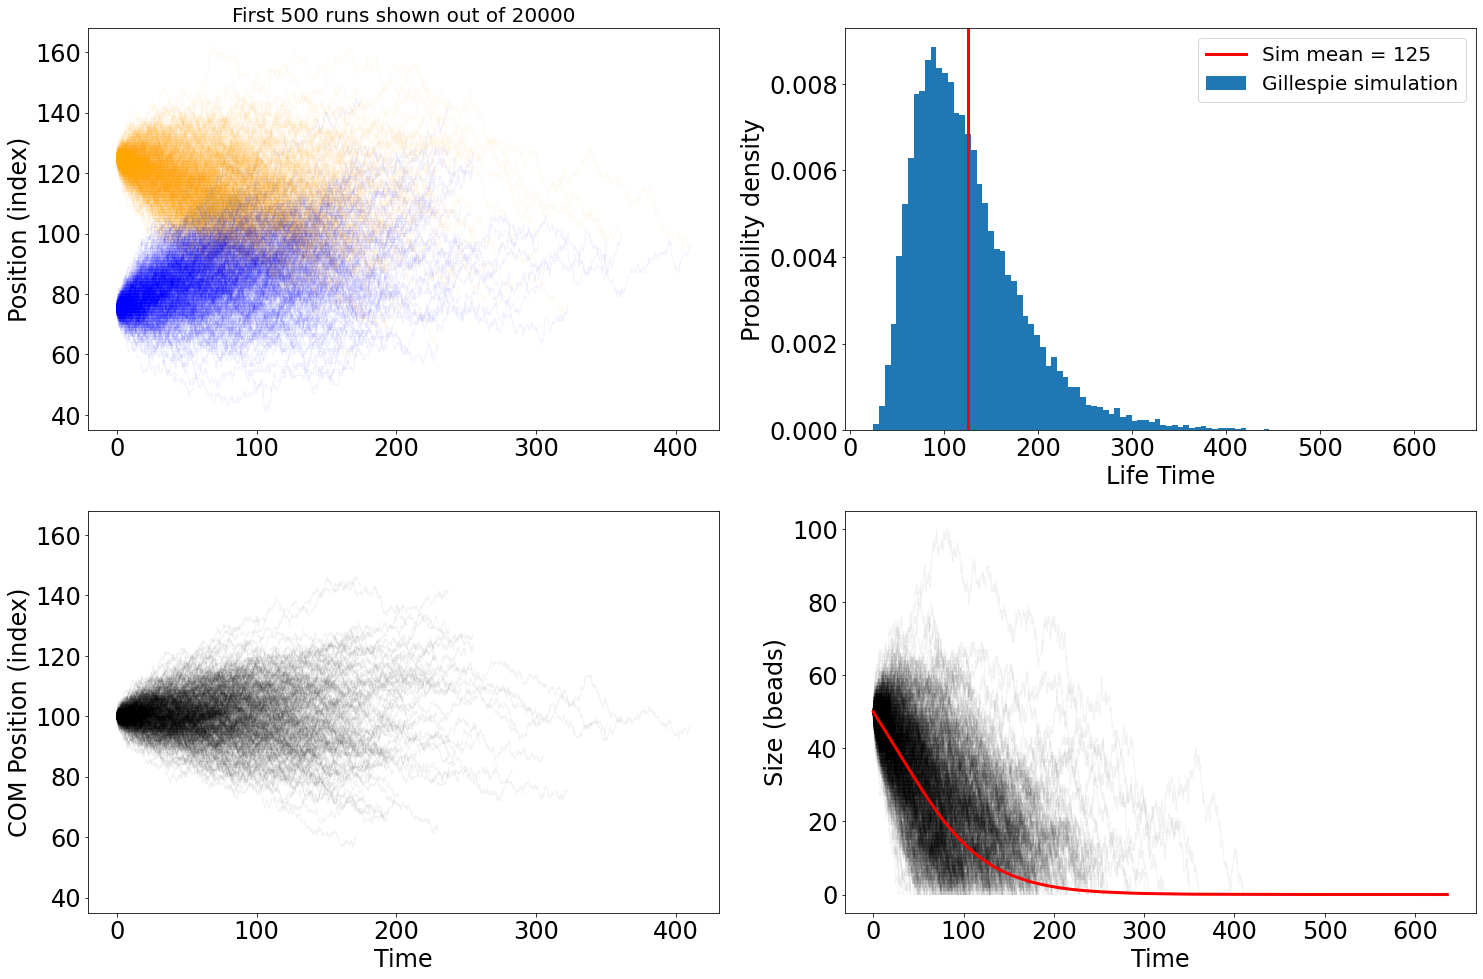

In [26]:
fig, axarr = plt.subplots(2, 2, figsize=(21, 14))
axarr[1,0].sharey(axarr[0,0])
n_graph_runs = 500
# A little name bashing
tmp_dict = g1_koff11_dict
tmp_fpt = tmp_dict['fpt']

avg_t_com_arr, avg_com_arr = aa.find_avg_val_arr(tmp_dict['time'], tmp_dict['com'], n_timesteps=1000)
avg_t_size_arr, avg_size_arr = aa.find_avg_val_arr(tmp_dict['time'], tmp_dict['size'], n_timesteps=1000)

for time_arr, state_arr, com_arr, size_arr in zip(tmp_dict['time'][:n_graph_runs],
                                                  tmp_dict['state'][:n_graph_runs],
                                                  tmp_dict['com'][:n_graph_runs],
                                                  tmp_dict['size'][:n_graph_runs]):

    _ = axarr[0][0].plot(time_arr, state_arr[:, 0], color='b', alpha=.05, lw=1)
    _ = axarr[0][0].plot(time_arr, state_arr[:, 1],
                         color='orange', alpha=.05, lw=1)
    _ = axarr[1][0].plot(time_arr, com_arr, color='k', alpha=.05, lw=1)
    _ = axarr[1][1].plot(time_arr, size_arr, color='k', alpha=.05, lw=1)
_ = axarr[1][1].plot(avg_t_size_arr, avg_size_arr, color='r')
    
    
# Simulation plotting
_ = axarr[0, 1].hist(tmp_fpt, density=True, bins=100,
                     label='Gillespie simulation')
_ = axarr[0, 1].axvline(np.mean(tmp_fpt), color='r',
                        label=f'Sim mean = {np.mean(tmp_fpt):.3g}')
_ = axarr[0, 0].set_title(
    f'First {n_graph_runs} runs shown out of {len(tmp_dict["time"])}')
#_ = axarr[1].plot(htime_arr, h_arr, label= "Analytic")
_ = axarr[1, 0].set_xlabel('Time')
_ = axarr[1, 1].set_xlabel('Time')
_ = axarr[0, 1].set_xlabel('Life Time')

_ = axarr[0, 0].set_ylabel('Position (index)')
_ = axarr[1, 0].set_ylabel('COM Position (index)')
_ = axarr[0, 1].set_ylabel('Probability density')
_ = axarr[1, 1].set_ylabel('Size (beads)')

_ = axarr[0, 1].legend()
#_ = axarr[1].set_yscale('log')
fig.tight_layout()

## Two blob simulations

In [308]:
g2_params = {
    'system_type': 'two_blobs',
    'n_beads' : 300, 
    'max_steps': 20000,
    'init_state': [[75,125], [175, 225]],
    'kinetics': {
        'func': 'const',
        'min_beads': 100,
        'kon': [[1.,1.],[1.,1.]],
        'koff': [[1.,1.],[1.,1.]]
    }
}

time_arr, state_arr = aa.run_gill_gen(rng_seed=1234, **g2_params)
#mid_point_arr = state_arr.mean(axis=-1)

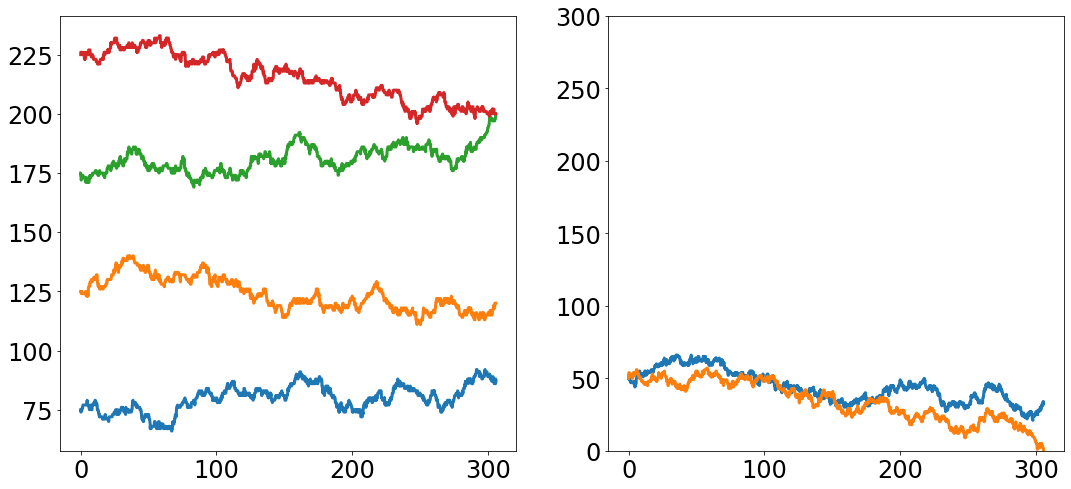

In [317]:
fig, axarr = plt.subplots(1,2, figsize=(18,8))
_ = axarr[0].plot(time_arr, state_arr.reshape(-1,4))
#_ = axarr[0].plot(time_arr, mid_point_arr)
    
_ = axarr[1].plot(time_arr, np.diff(state_arr, axis=-1).reshape(-1,2))
_ = axarr[1].set_ylim(0, 300)

In [6]:
g2_params = {
    'system_type': 'two_blobs',
    'n_beads' : 300, 
    'max_steps': 20000,
    'init_state': [[75,125], [175, 225]],
    'kinetics': {
        'func': 'const',
        'min_beads': 100,
        'kon': [[1.1,1.1],[1.1,1.1]],
        'koff': [[1.,1.],[1.,1.]]
    }
}

time_arr, state_arr = aa.run_gill_gen(rng_seed=1234, **g2_params)
#mid_point_arr = state_arr.mean(axis=-1)

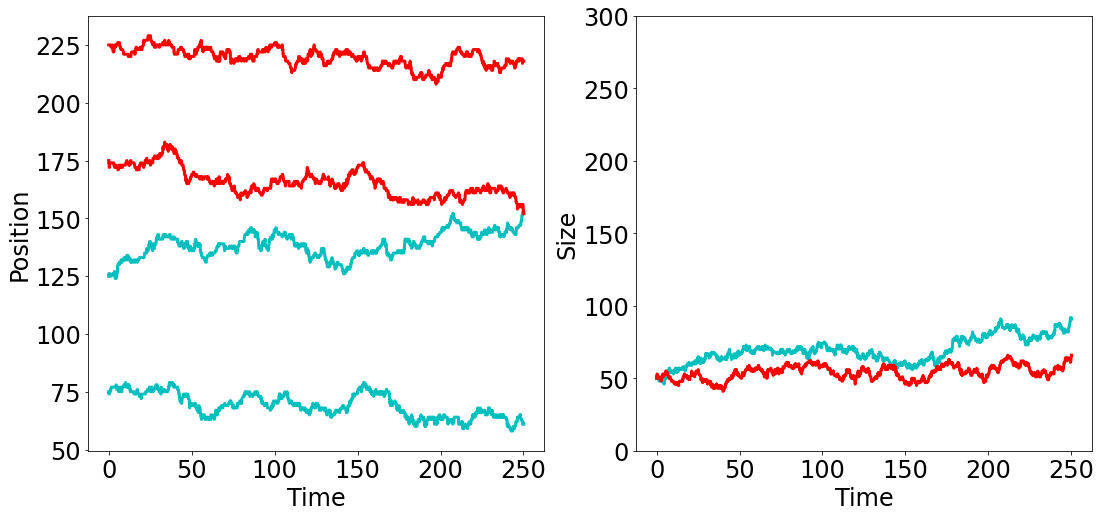

In [11]:
fig, axarr = plt.subplots(1,2, figsize=(18,8))
axarr[0].set_prop_cycle(color=['c','c','r','r'])
axarr[1].set_prop_cycle(color=['c','r'])
_ = axarr[0].plot(time_arr, state_arr.reshape(-1,4))
#_ = axarr[0].plot(time_arr, mid_point_arr)
    
_ = axarr[1].plot(time_arr, np.diff(state_arr, axis=-1).reshape(-1,2))
_ = axarr[0].set_xlabel('Time')
_ = axarr[0].set_ylabel('Position')
_ = axarr[1].set_xlabel('Time')
_ = axarr[1].set_ylabel('Size')
_ = axarr[1].set_ylim(0, 300)

In [13]:
g2_params = {
    'system_type': 'two_blobs',
    'n_beads' : 300, 
    'max_steps': 20000,
    'init_state': [[75,125], [175, 225]],
    'kinetics': {
        'func': 'const',
        'min_beads': 100,
        'kon': [[1.1,1.1],[1.,1.]],
        'koff': [[1.,1.],[1.,1.]]
    }
}

time_arr, state_arr = aa.run_gill_gen(rng_seed=1234, **g2_params)
mid_point_arr = state_arr.mean(axis=-1)

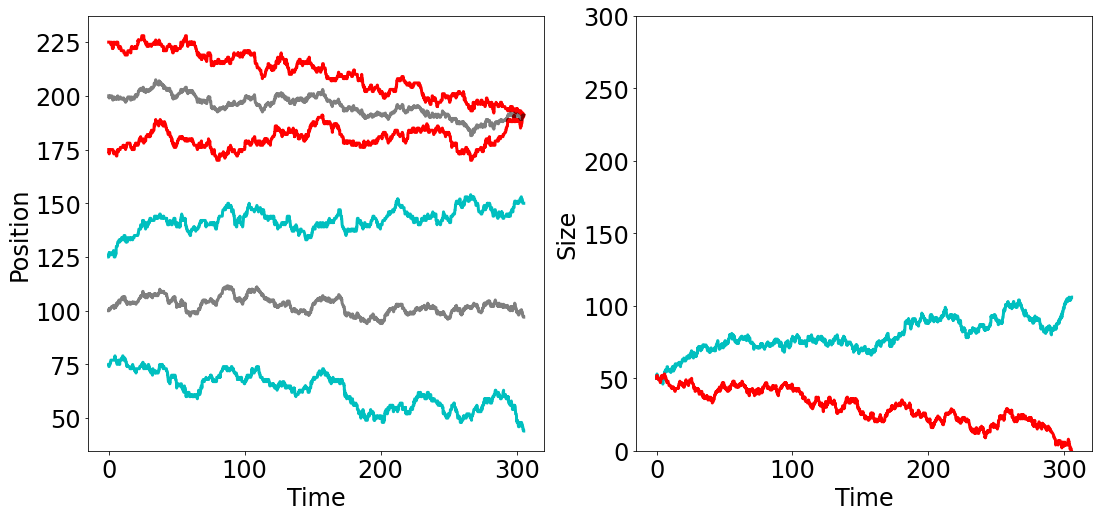

In [19]:
fig, axarr = plt.subplots(1,2, figsize=(18,8))
axarr[0].set_prop_cycle(color=['c','c','r','r'])
axarr[1].set_prop_cycle(color=['c','r'])
_ = axarr[0].plot(time_arr, state_arr.reshape(-1,4))

#axarr[0].set_prop_cycle(cyc)
#cyc = cycler(color=['c','m'])

_ = axarr[0].plot(time_arr, mid_point_arr, c='k', alpha=.5)
#_ = axarr[0].plot(time_arr, mid_point_arr, color='m')
#axarr[1].set_prop_cycle(cyc)
_ = axarr[0].set_xlabel('Time')
_ = axarr[0].set_ylabel('Position')
_ = axarr[1].set_xlabel('Time')
_ = axarr[1].set_ylabel('Size')
_ = axarr[1].plot(time_arr, np.diff(state_arr, axis=-1).reshape(-1,2))
_ = axarr[1].set_ylim(0, 300)

In [356]:
cycles = 20000

g2_params = {
    'system_type': 'two_blobs',
    'n_beads' : 400, 
    'max_steps': -1,
    'init_state': [[75,125],[275,325]],
    'kinetics': {
        'func': 'const',
        'min_beads': 100,
        'kon': [[1.,1.],[1.,1.]],
        'koff': [[1.,1.],[1.,1.]]
    }
}

data_dict = { 'params': g2_params,
              'time': [],
              'state': [],
              'coms' : [],
              'merge_times' : [],
              'dissolve_times': [],
              'sizes' : [],
                  }



for i in tqdm(range(1, cycles+1)):
    time_arr, state_arr = aa.run_gill_gen(rng_seed=2*i, **g2_params)
    data_dict['time'] += [time_arr]
    data_dict['state'] += [state_arr]
    data_dict['sizes'] += [np.diff(state_arr, axis=-1).reshape(-1,2)]
    data_dict['coms'] += [state_arr.mean(axis=-1)]
    data_dict['merge_times'] += [time_arr[-1]] if state_arr[-1,0,1] == state_arr[-1,1,0] else []
    data_dict['dissolve_times'] += [time_arr[-1]] if state_arr[-1,0,0] == state_arr[-1,0,1] or state_arr[-1,1,0] == state_arr[-1,1,1] else []

g2_base_dict = deepcopy(data_dict)


  0%|          | 0/20000 [00:00<?, ?it/s]

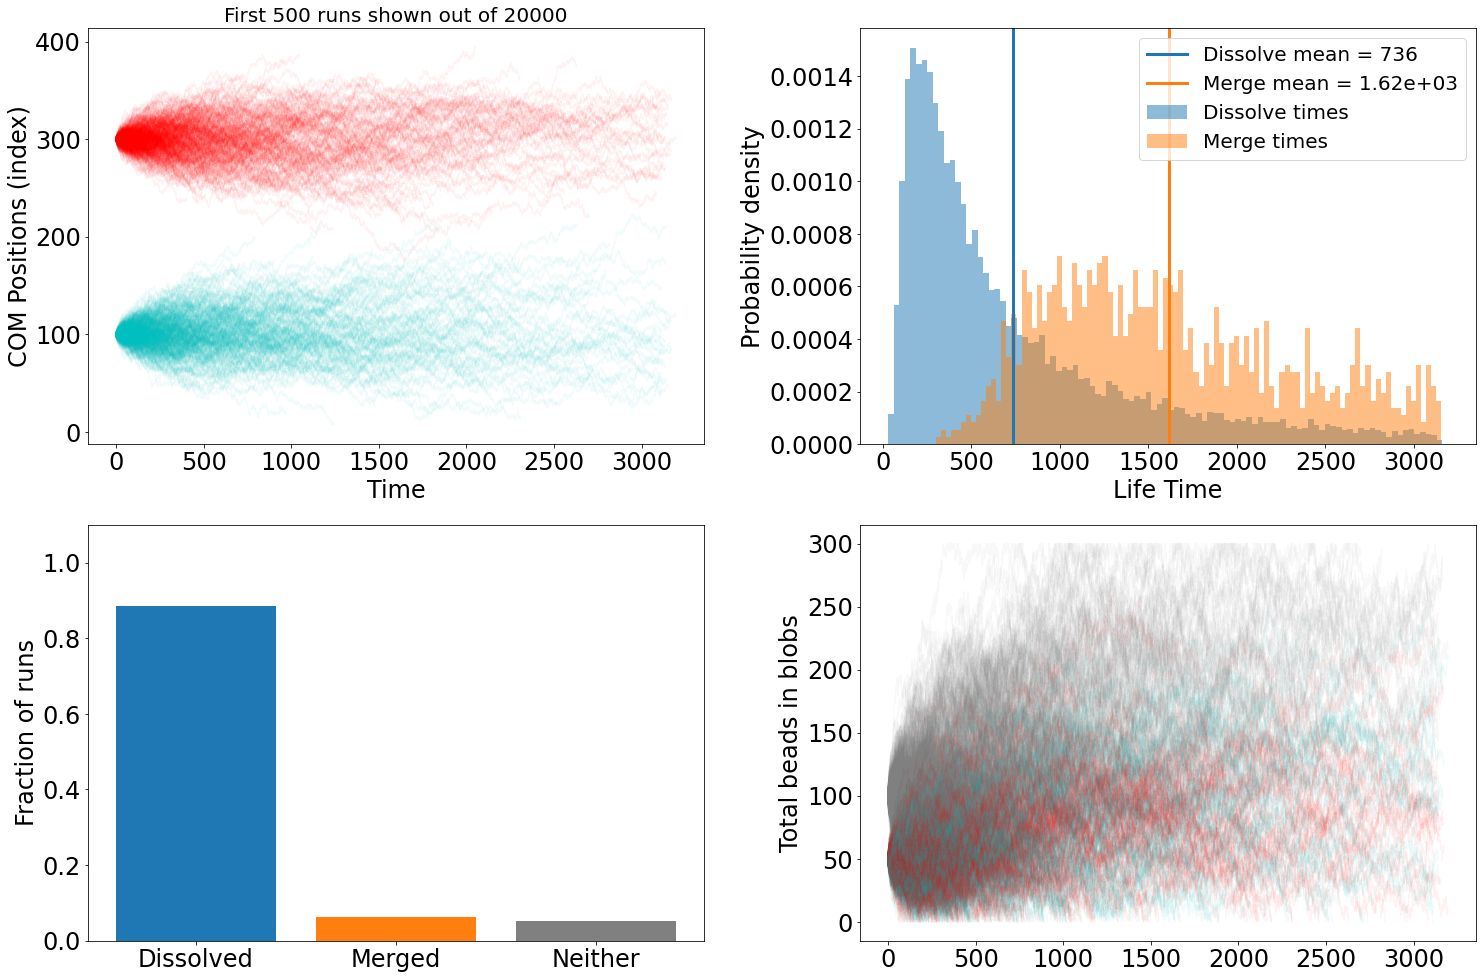

In [360]:
# A little name bashing
tmp_dict = g2_base_dict
tmp_dst = tmp_dict['dissolve_times']
tmp_mt = tmp_dict['merge_times']

fig, axarr = plt.subplots(2, 2, figsize=(21, 14))
n_graph_runs = 500
#avg_t_com_arr, avg_com_arr = aa.find_avg_val_arr(tmp_dict['time'], tmp_dict['com'], n_timesteps=1000)
#avg_t_size_arr, avg_size_arr = aa.find_avg_val_arr(tmp_dict['time'], tmp_dict['size'], n_timesteps=1000)
cyc = cycler(color=['c','r'])
axarr[0,0].set_prop_cycle(cyc)
axarr[1,1].set_prop_cycle(cyc)
for time_arr, state_arr, com_arr, size_arr in zip(tmp_dict['time'][:n_graph_runs],
                                                  tmp_dict['state'][:n_graph_runs],
                                                  tmp_dict['coms'][:n_graph_runs],
                                                  tmp_dict['sizes'][:n_graph_runs]):

    _ = axarr[0,0].plot(time_arr, com_arr, alpha=.05, lw=1)
   # _ = axarr[0,0].plot(time_arr, com_arr[:, 1],
                         #color='orange', alpha=.05, lw=1)
#    _ = axarr[1][0].plot(time_arr, com_arr, color='k', alpha=.05, lw=1)
    _ = axarr[1][1].plot(time_arr, size_arr, alpha=.05, lw=1)
    _ = axarr[1][1].plot(time_arr, size_arr.sum(axis=-1), color='gray', alpha=.05, lw=1)
#_ = axarr[1][1].plot(avg_t_size_arr, avg_size_arr, color='r')
    
    
# Simulation plotting
_ = axarr[0, 1].hist(tmp_dst, density=True, bins=100,
                     label='Dissolve times',alpha=.5)
_ = axarr[0, 1].axvline(np.mean(tmp_dst), color='tab:blue',
                        label=f'Dissolve mean = {np.mean(tmp_dst):.3g}')
_ = axarr[0, 1].hist(tmp_mt, density=True, bins=100,
                     label='Merge times',alpha=.5)
_ = axarr[0, 1].axvline(np.mean(tmp_mt), color='tab:orange',
                        label=f'Merge mean = {np.mean(tmp_mt):.3g}')


_ = axarr[1,0].bar(range(3), [float(len(tmp_dst)/cycles), float(len(tmp_mt)/cycles), float(cycles-len(tmp_dst) -len(tmp_mt))/cycles], color=['tab:blue', 'tab:orange', 'gray'])
_ = axarr[1,0].set_xticks(range(3))
_ = axarr[1,0].set_xticklabels(['Dissolved', 'Merged', 'Neither'])

_ = axarr[1,0].set_ylim(0,1.1)

# Labeling
_ = axarr[0, 0].set_title(
    f'First {n_graph_runs} runs shown out of {len(tmp_dict["time"])}')

_ = axarr[0, 0].set_xlabel('Time')
_ = axarr[0, 1].set_xlabel('Life Time')

_ = axarr[0, 0].set_ylabel('COM Positions (index)')
_ = axarr[1, 0].set_ylabel("Fraction of runs")
_ = axarr[0, 1].set_ylabel('Probability density')
_ = axarr[1, 1].set_ylabel('Total beads in blobs')

_ = axarr[0, 1].legend()
#_ = axarr[1].set_yscale('log')
fig.tight_layout()

In [27]:
cycles = 20000

g2_params = {
    'system_type': 'two_blobs',
    'n_beads' : 400, 
    'max_steps': -1,
    'init_state': [[75,125],[275,325]],
    'kinetics': {
        'func': 'const',
        'min_beads': 100,
        'kon': [[1.,1.],[1.,1.]],
        'koff': [[1.,1.],[1.,1.]]
    }
}

data_dict = { 'params': g2_params,
              'time': [],
              'state': [],
              'coms' : [],
              'merge_times' : [],
              'dissolve_times': [],
              'sizes' : [],
                  }



for i in tqdm(range(1, cycles+1)):
    time_arr, state_arr = aa.run_gill_gen(rng_seed=2*i, **g2_params)
    data_dict['time'] += [time_arr]
    data_dict['state'] += [state_arr]
    data_dict['sizes'] += [np.diff(state_arr, axis=-1).reshape(-1,2)]
    data_dict['coms'] += [state_arr.mean(axis=-1)]
    data_dict['merge_times'] += [time_arr[-1]] if state_arr[-1,0,1] == state_arr[-1,1,0] else []
    data_dict['dissolve_times'] += [time_arr[-1]] if state_arr[-1,0,0] == state_arr[-1,0,1] or state_arr[-1,1,0] == state_arr[-1,1,1] else []

g2_base_long_dict = deepcopy(data_dict)


  0%|          | 0/20000 [00:00<?, ?it/s]

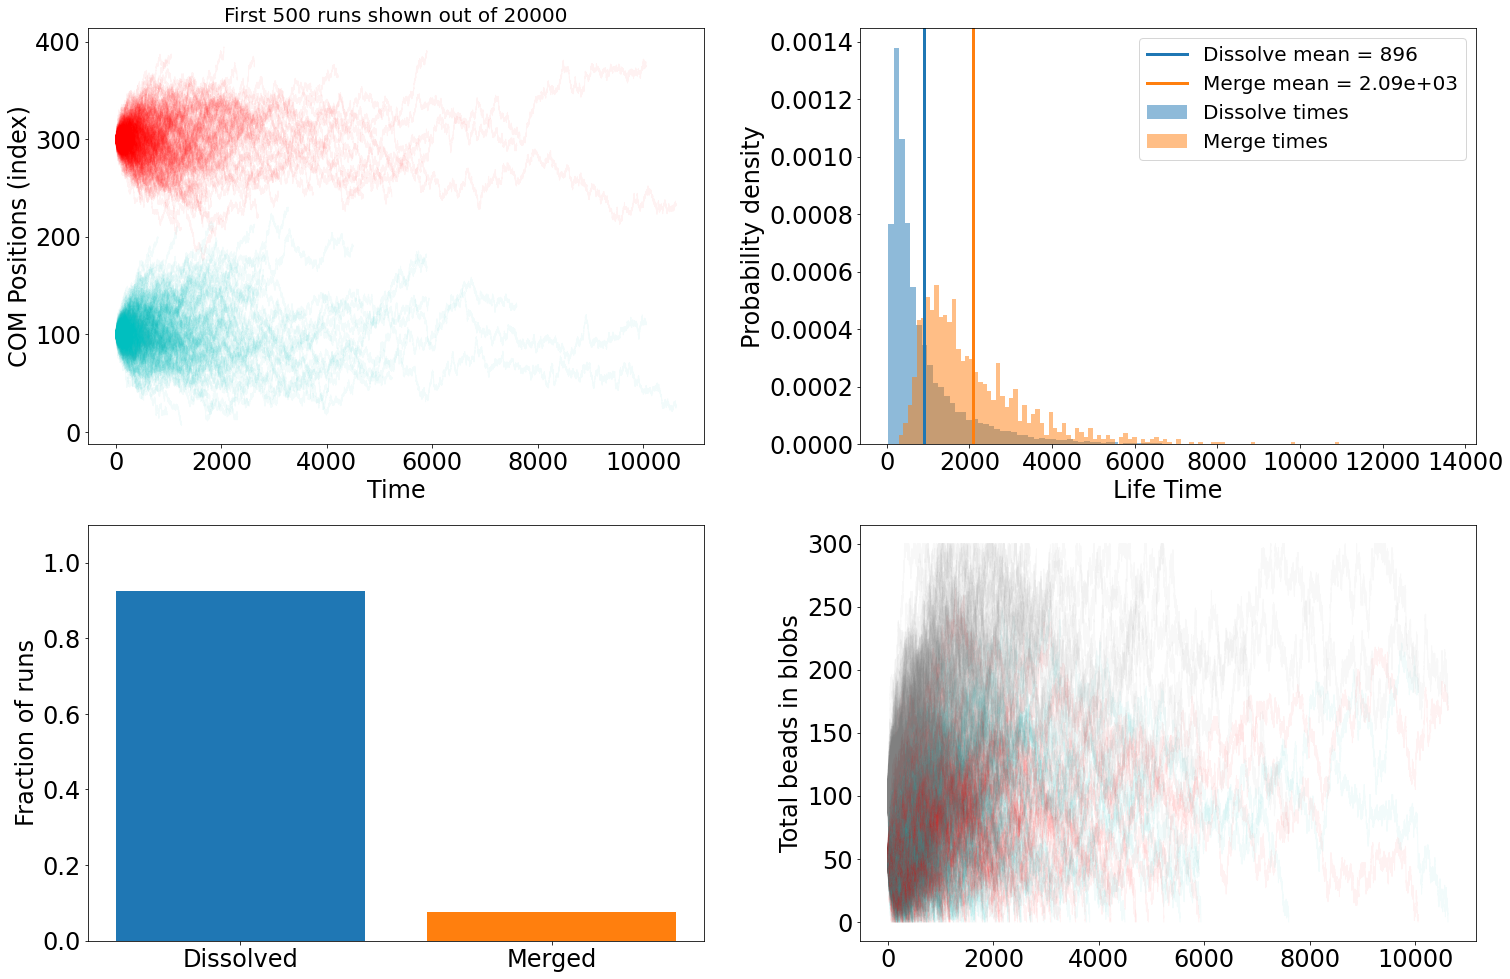

In [33]:

# A little name bashing
tmp_dict = g2_base_long_dict
tmp_dst = tmp_dict['dissolve_times']
tmp_mt = tmp_dict['merge_times']

fig, axarr = plt.subplots(2, 2, figsize=(21, 14))
n_graph_runs = 500
#avg_t_com_arr, avg_com_arr = aa.find_avg_val_arr(tmp_dict['time'], tmp_dict['com'], n_timesteps=1000)
#avg_t_size_arr, avg_size_arr = aa.find_avg_val_arr(tmp_dict['time'], tmp_dict['size'], n_timesteps=1000)
cyc = cycler(color=['c','r'])
axarr[0,0].set_prop_cycle(cyc)
axarr[1,1].set_prop_cycle(cyc)
for time_arr, state_arr, com_arr, size_arr in zip(tmp_dict['time'][:n_graph_runs],
                                                  tmp_dict['state'][:n_graph_runs],
                                                  tmp_dict['coms'][:n_graph_runs],
                                                  tmp_dict['sizes'][:n_graph_runs]):

    _ = axarr[0,0].plot(time_arr, com_arr, alpha=.05, lw=1)
   # _ = axarr[0,0].plot(time_arr, com_arr[:, 1],
                         #color='orange', alpha=.05, lw=1)
#    _ = axarr[1][0].plot(time_arr, com_arr, color='k', alpha=.05, lw=1)
    _ = axarr[1][1].plot(time_arr, size_arr, alpha=.05, lw=1)
    _ = axarr[1][1].plot(time_arr, size_arr.sum(axis=-1), color='gray', alpha=.05, lw=1)
#_ = axarr[1][1].plot(avg_t_size_arr, avg_size_arr, color='r')
    
    
# Simulation plotting
_ = axarr[0, 1].hist(tmp_dst, density=True, bins=100,
                     label='Dissolve times',alpha=.5)
_ = axarr[0, 1].axvline(np.mean(tmp_dst), color='tab:blue',
                        label=f'Dissolve mean = {np.mean(tmp_dst):.3g}')
_ = axarr[0, 1].hist(tmp_mt, density=True, bins=100,
                     label='Merge times',alpha=.5)
_ = axarr[0, 1].axvline(np.mean(tmp_mt), color='tab:orange',
                        label=f'Merge mean = {np.mean(tmp_mt):.3g}')


_ = axarr[1,0].bar(range(2), [float(len(tmp_dst)/cycles), float(len(tmp_mt)/cycles)], color=['tab:blue', 'tab:orange'])
_ = axarr[1,0].set_xticks(range(2))
_ = axarr[1,0].set_xticklabels(['Dissolved', 'Merged'])

_ = axarr[1,0].set_ylim(0,1.1)

# Labeling
_ = axarr[0, 0].set_title(
    f'First {n_graph_runs} runs shown out of {len(tmp_dict["time"])}')

_ = axarr[0, 0].set_xlabel('Time')
_ = axarr[0, 1].set_xlabel('Life Time')

_ = axarr[0, 0].set_ylabel('COM Positions (index)')
_ = axarr[1, 0].set_ylabel("Fraction of runs")
_ = axarr[0, 1].set_ylabel('Probability density')
_ = axarr[1, 1].set_ylabel('Total beads in blobs')

_ = axarr[0, 1].legend()
#_ = axarr[1].set_yscale('log')
fig.tight_layout()

In [361]:
cycles = 20000

g2_params = {
    'system_type': 'two_blobs',
    'n_beads' : 400, 
    'max_steps': 25000,
    'init_state': [[100,150],[250,300]],
    'kinetics': {
        'func': 'const',
        'min_beads': 100,
        'kon': [[1.,1.],[1.,1.]],
        'koff': [[1.,1.],[1.,1.]]
    }
}

data_dict = { 'params': g2_params,
              'time': [],
              'state': [],
              'coms' : [],
              'merge_times' : [],
              'dissolve_times': [],
              'sizes' : [],
                  }



for i in tqdm(range(1, cycles+1)):
    time_arr, state_arr = aa.run_gill_gen(rng_seed=2*i, **g2_params)
    data_dict['time'] += [time_arr]
    data_dict['state'] += [state_arr]
    data_dict['sizes'] += [np.diff(state_arr, axis=-1).reshape(-1,2)]
    data_dict['coms'] += [state_arr.mean(axis=-1)]
    data_dict['merge_times'] += [time_arr[-1]] if state_arr[-1,0,1] == state_arr[-1,1,0] else []
    data_dict['dissolve_times'] += [time_arr[-1]] if state_arr[-1,0,0] == state_arr[-1,0,1] or state_arr[-1,1,0] == state_arr[-1,1,1] else []

g2_sep100_dict = deepcopy(data_dict)


  0%|          | 0/20000 [00:00<?, ?it/s]

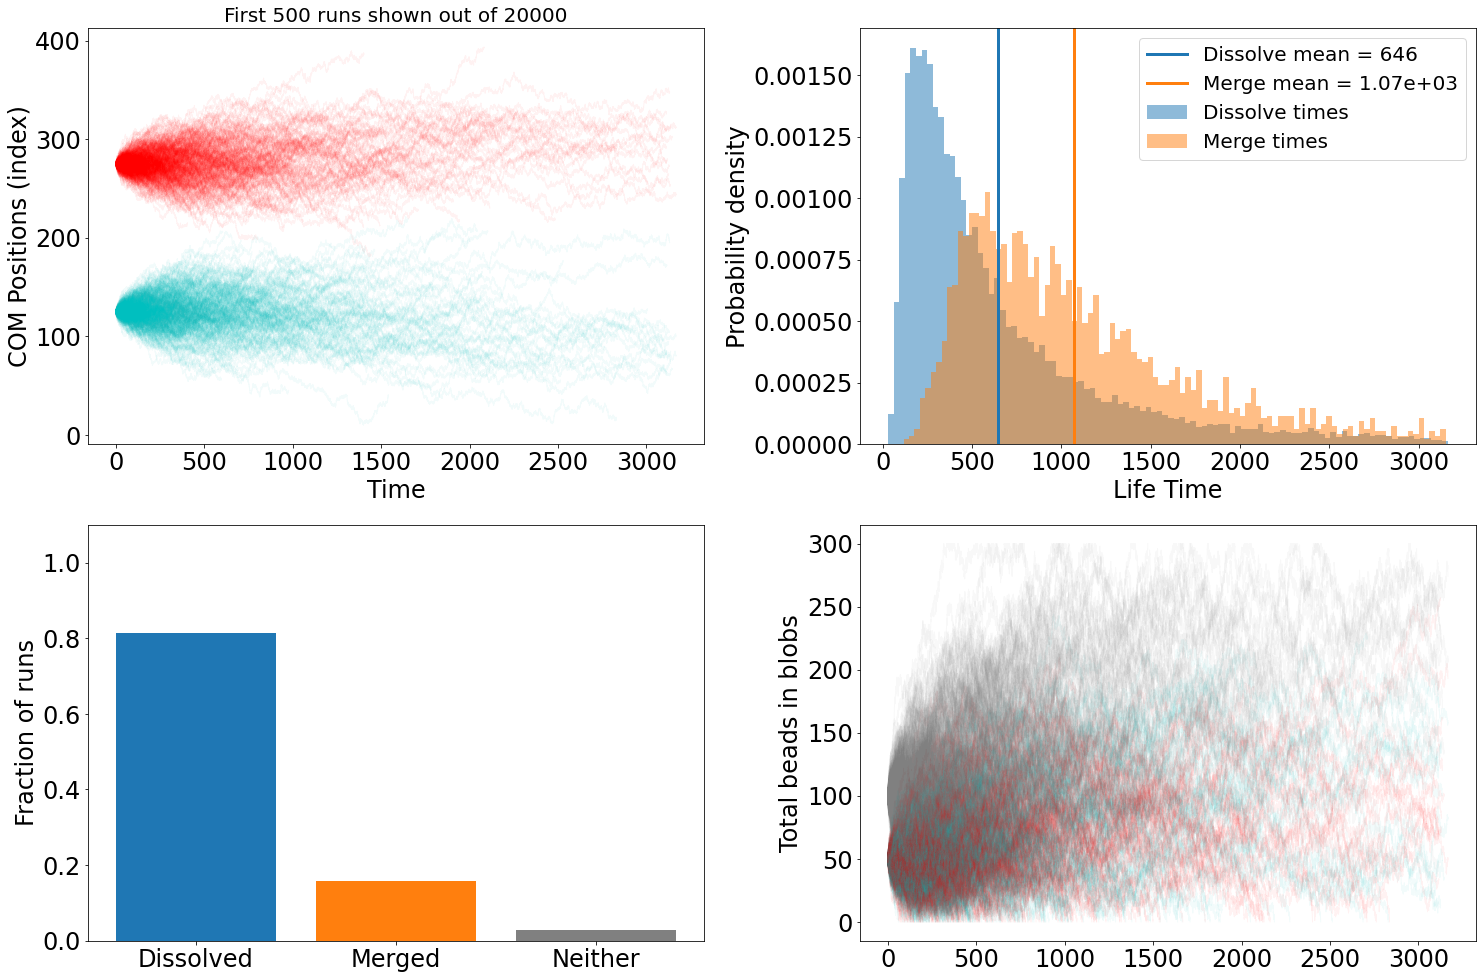

In [362]:
# A little name bashing
tmp_dict = g2_sep100_dict
tmp_dst = tmp_dict['dissolve_times']
tmp_mt = tmp_dict['merge_times']

fig, axarr = plt.subplots(2, 2, figsize=(21, 14))
n_graph_runs = 500
#avg_t_com_arr, avg_com_arr = aa.find_avg_val_arr(tmp_dict['time'], tmp_dict['com'], n_timesteps=1000)
#avg_t_size_arr, avg_size_arr = aa.find_avg_val_arr(tmp_dict['time'], tmp_dict['size'], n_timesteps=1000)
cyc = cycler(color=['c','r'])
axarr[0,0].set_prop_cycle(cyc)
axarr[1,1].set_prop_cycle(cyc)
for time_arr, state_arr, com_arr, size_arr in zip(tmp_dict['time'][:n_graph_runs],
                                                  tmp_dict['state'][:n_graph_runs],
                                                  tmp_dict['coms'][:n_graph_runs],
                                                  tmp_dict['sizes'][:n_graph_runs]):

    _ = axarr[0,0].plot(time_arr, com_arr, alpha=.05, lw=1)
   # _ = axarr[0,0].plot(time_arr, com_arr[:, 1],
                         #color='orange', alpha=.05, lw=1)
#    _ = axarr[1][0].plot(time_arr, com_arr, color='k', alpha=.05, lw=1)
    _ = axarr[1][1].plot(time_arr, size_arr, alpha=.05, lw=1)
    _ = axarr[1][1].plot(time_arr, size_arr.sum(axis=-1), color='gray', alpha=.05, lw=1)
#_ = axarr[1][1].plot(avg_t_size_arr, avg_size_arr, color='r')
    
    
# Simulation plotting
_ = axarr[0, 1].hist(tmp_dst, density=True, bins=100,
                     label='Dissolve times',alpha=.5)
_ = axarr[0, 1].axvline(np.mean(tmp_dst), color='tab:blue',
                        label=f'Dissolve mean = {np.mean(tmp_dst):.3g}')
_ = axarr[0, 1].hist(tmp_mt, density=True, bins=100,
                     label='Merge times',alpha=.5)
_ = axarr[0, 1].axvline(np.mean(tmp_mt), color='tab:orange',
                        label=f'Merge mean = {np.mean(tmp_mt):.3g}')


_ = axarr[1,0].bar(range(3), [float(len(tmp_dst)/cycles), float(len(tmp_mt)/cycles), float(cycles-len(tmp_dst) -len(tmp_mt))/cycles], color=['tab:blue', 'tab:orange', 'gray'])
_ = axarr[1,0].set_xticks(range(3))
_ = axarr[1,0].set_xticklabels(['Dissolved', 'Merged', 'Neither'])

_ = axarr[1,0].set_ylim(0,1.1)

# Labeling
_ = axarr[0, 0].set_title(
    f'First {n_graph_runs} runs shown out of {len(tmp_dict["time"])}')

_ = axarr[0, 0].set_xlabel('Time')
_ = axarr[0, 1].set_xlabel('Life Time')

_ = axarr[0, 0].set_ylabel('COM Positions (index)')
_ = axarr[1, 0].set_ylabel("Fraction of runs")
_ = axarr[0, 1].set_ylabel('Probability density')
_ = axarr[1, 1].set_ylabel('Total beads in blobs')

_ = axarr[0, 1].legend()
#_ = axarr[1].set_yscale('log')
fig.tight_layout()

In [34]:
cycles = 20000

g2_params = {
    'system_type': 'two_blobs',
    'n_beads' : 400, 
    'max_steps': -1,
    'init_state': [[100,150],[250,300]],
    'kinetics': {
        'func': 'const',
        'min_beads': 100,
        'kon': [[1.,1.],[1.,1.]],
        'koff': [[1.,1.],[1.,1.]]
    }
}

data_dict = { 'params': g2_params,
              'time': [],
              'state': [],
              'coms' : [],
              'merge_times' : [],
              'dissolve_times': [],
              'sizes' : [],
                  }



for i in tqdm(range(1, cycles+1)):
    time_arr, state_arr = aa.run_gill_gen(rng_seed=2*i, **g2_params)
    data_dict['time'] += [time_arr]
    data_dict['state'] += [state_arr]
    data_dict['sizes'] += [np.diff(state_arr, axis=-1).reshape(-1,2)]
    data_dict['coms'] += [state_arr.mean(axis=-1)]
    data_dict['merge_times'] += [time_arr[-1]] if state_arr[-1,0,1] == state_arr[-1,1,0] else []
    data_dict['dissolve_times'] += [time_arr[-1]] if state_arr[-1,0,0] == state_arr[-1,0,1] or state_arr[-1,1,0] == state_arr[-1,1,1] else []

g2_sep100_long_dict = deepcopy(data_dict)


  0%|          | 0/20000 [00:00<?, ?it/s]

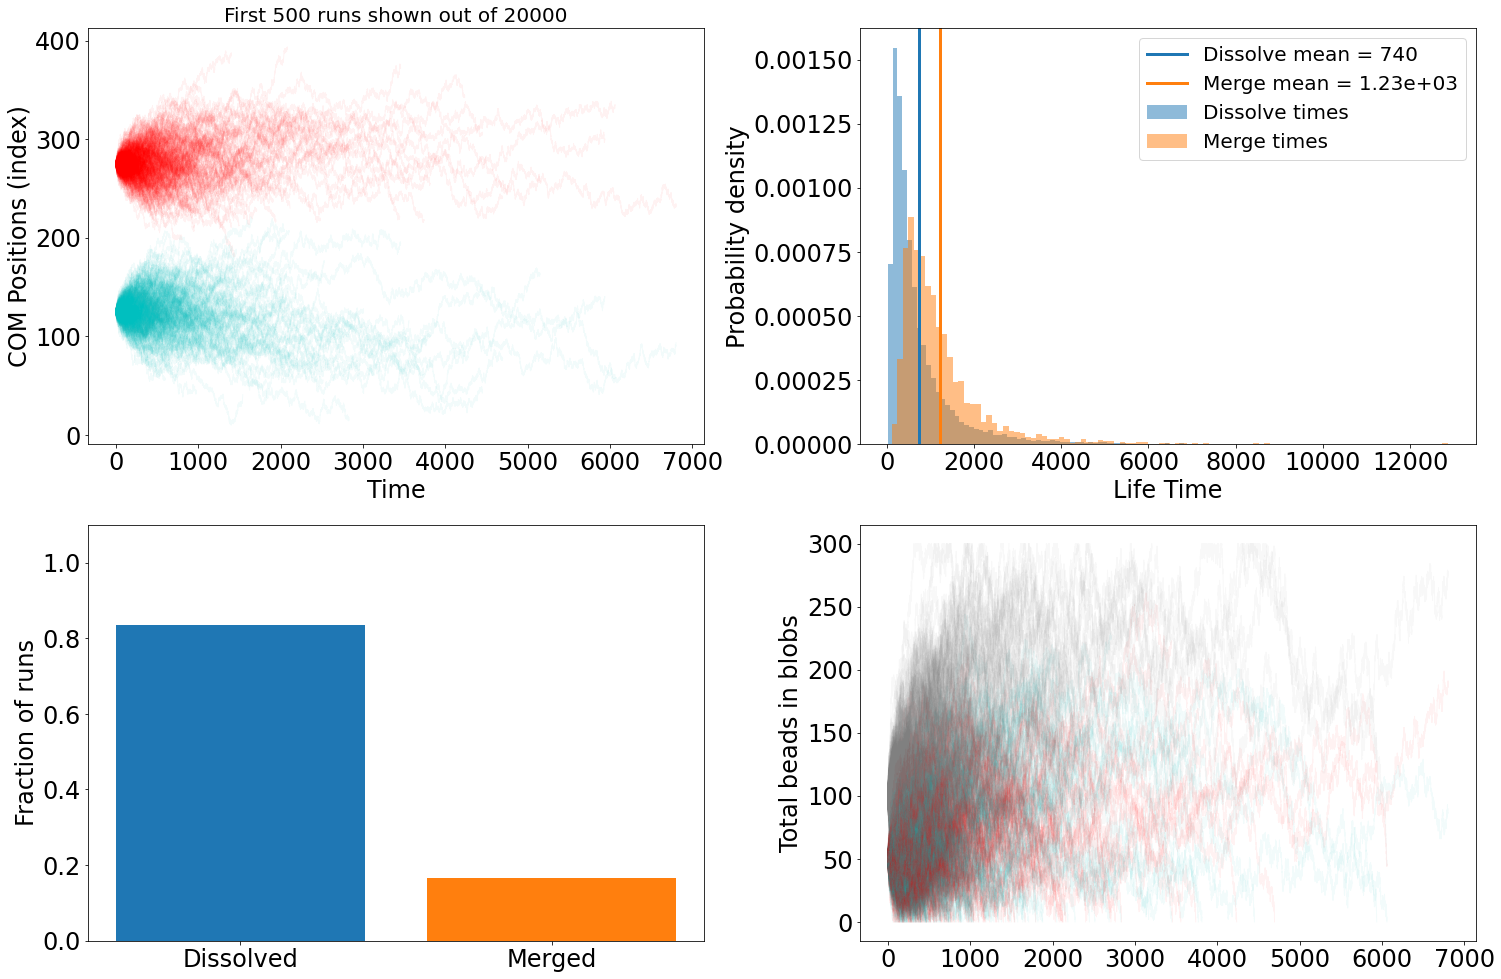

In [36]:
# A little name bashing
tmp_dict = g2_sep100_long_dict
tmp_dst = tmp_dict['dissolve_times']
tmp_mt = tmp_dict['merge_times']

fig, axarr = plt.subplots(2, 2, figsize=(21, 14))
n_graph_runs = 500
#avg_t_com_arr, avg_com_arr = aa.find_avg_val_arr(tmp_dict['time'], tmp_dict['com'], n_timesteps=1000)
#avg_t_size_arr, avg_size_arr = aa.find_avg_val_arr(tmp_dict['time'], tmp_dict['size'], n_timesteps=1000)
cyc = cycler(color=['c','r'])
axarr[0,0].set_prop_cycle(cyc)
axarr[1,1].set_prop_cycle(cyc)
for time_arr, state_arr, com_arr, size_arr in zip(tmp_dict['time'][:n_graph_runs],
                                                  tmp_dict['state'][:n_graph_runs],
                                                  tmp_dict['coms'][:n_graph_runs],
                                                  tmp_dict['sizes'][:n_graph_runs]):

    _ = axarr[0,0].plot(time_arr, com_arr, alpha=.05, lw=1)
   # _ = axarr[0,0].plot(time_arr, com_arr[:, 1],
                         #color='orange', alpha=.05, lw=1)
#    _ = axarr[1][0].plot(time_arr, com_arr, color='k', alpha=.05, lw=1)
    _ = axarr[1][1].plot(time_arr, size_arr, alpha=.05, lw=1)
    _ = axarr[1][1].plot(time_arr, size_arr.sum(axis=-1), color='gray', alpha=.05, lw=1)
#_ = axarr[1][1].plot(avg_t_size_arr, avg_size_arr, color='r')
    
    
# Simulation plotting
_ = axarr[0, 1].hist(tmp_dst, density=True, bins=100,
                     label='Dissolve times',alpha=.5)
_ = axarr[0, 1].axvline(np.mean(tmp_dst), color='tab:blue',
                        label=f'Dissolve mean = {np.mean(tmp_dst):.3g}')
_ = axarr[0, 1].hist(tmp_mt, density=True, bins=100,
                     label='Merge times',alpha=.5)
_ = axarr[0, 1].axvline(np.mean(tmp_mt), color='tab:orange',
                        label=f'Merge mean = {np.mean(tmp_mt):.3g}')


_ = axarr[1,0].bar(range(2), [float(len(tmp_dst)/cycles), float(len(tmp_mt)/cycles)], color=['tab:blue', 'tab:orange'])
_ = axarr[1,0].set_xticks(range(2))
_ = axarr[1,0].set_xticklabels(['Dissolved', 'Merged'])

_ = axarr[1,0].set_ylim(0,1.1)

# Labeling
_ = axarr[0, 0].set_title(
    f'First {n_graph_runs} runs shown out of {len(tmp_dict["time"])}')

_ = axarr[0, 0].set_xlabel('Time')
_ = axarr[0, 1].set_xlabel('Life Time')

_ = axarr[0, 0].set_ylabel('COM Positions (index)')
_ = axarr[1, 0].set_ylabel("Fraction of runs")
_ = axarr[0, 1].set_ylabel('Probability density')
_ = axarr[1, 1].set_ylabel('Total beads in blobs')

_ = axarr[0, 1].legend()
#_ = axarr[1].set_yscale('log')
fig.tight_layout()

In [335]:
cycles = 10000

g2_params = {
    'system_type': 'two_blobs',
    'n_beads' : 400, 
    'max_steps': 20000,
    'init_state': [[75,125],[275,325]],
    'kinetics': {
        'func': 'const',
        'min_beads': 100,
        'kon': [[1.1,1.1],[1.,1.]],
        'koff': [[1.,1.],[1.,1.]]
    }
}

data_dict = { 'params': g2_params,
              'time': [],
              'state': [],
              'coms' : [],
              'merge_times' : [],
              'dissolve_times': [],
              'sizes' : [],
                  }



for i in tqdm(range(1, cycles+1)):
    time_arr, state_arr = aa.run_gill_gen(rng_seed=2*i, **g2_params)
    data_dict['time'] += [time_arr]
    data_dict['state'] += [state_arr]
    data_dict['sizes'] += [np.diff(state_arr, axis=-1).reshape(-1,2)]
    data_dict['coms'] += [state_arr.mean(axis=-1)]
    data_dict['merge_times'] += [time_arr[-1]] if state_arr[-1,0,1] == state_arr[-1,1,0] else []
    data_dict['dissolve_times'] += [time_arr[-1]] if state_arr[-1,0,0] == state_arr[-1,0,1] or state_arr[-1,1,0] == state_arr[-1,1,1] else []

g2_k011_dict = deepcopy(data_dict)


  0%|          | 0/10000 [00:00<?, ?it/s]

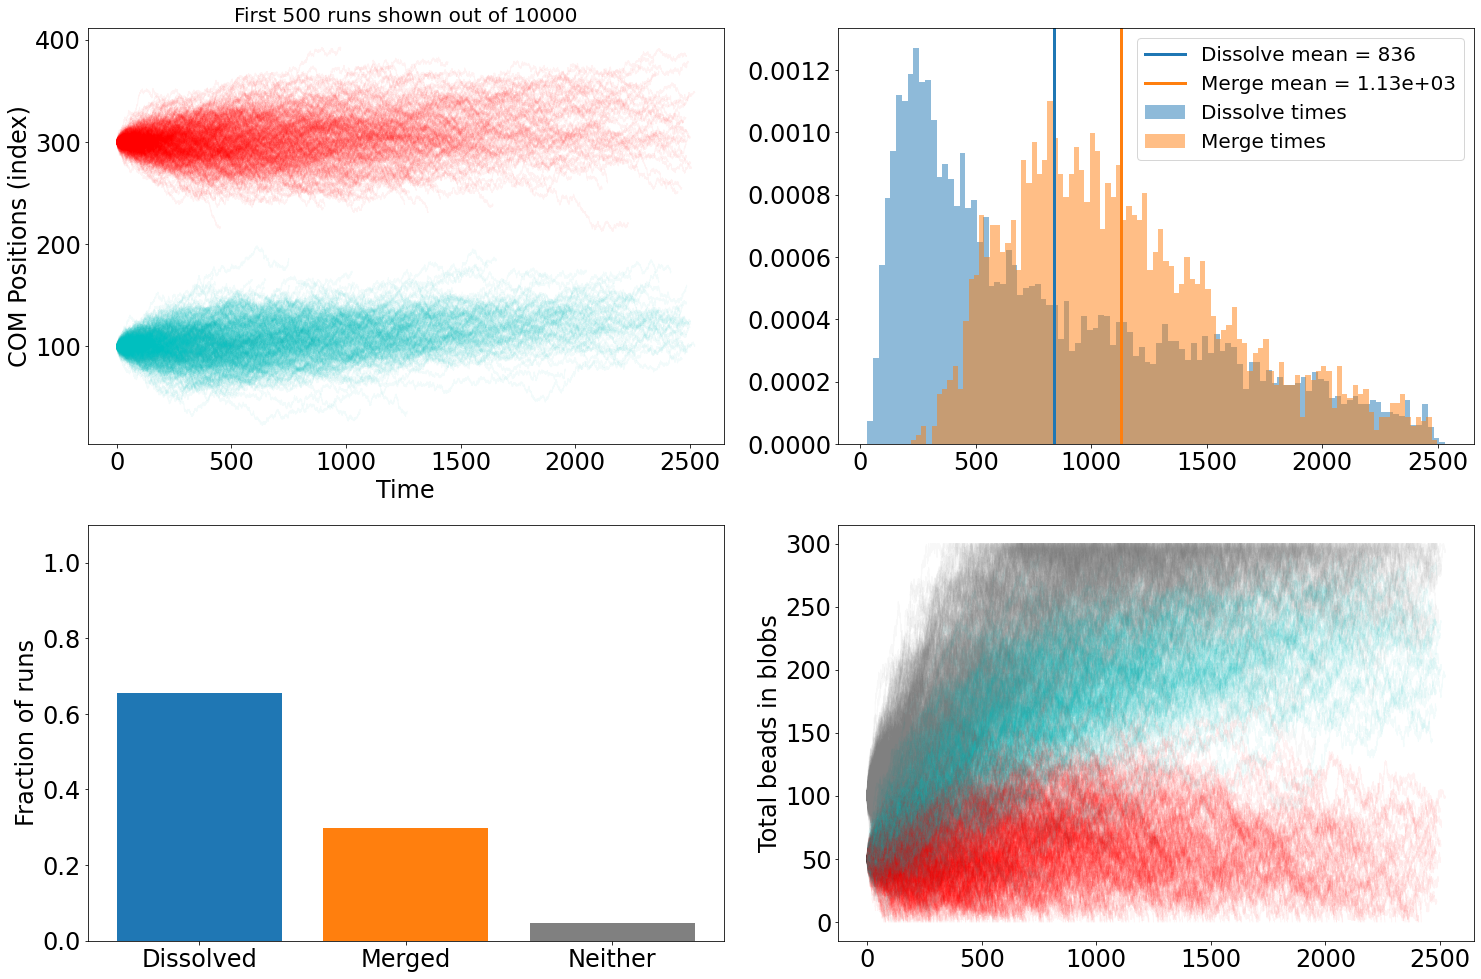

In [354]:
# A little name bashing
tmp_dict = g2_k011_dict
tmp_dst = tmp_dict['dissolve_times']
tmp_mt = tmp_dict['merge_times']

fig, axarr = plt.subplots(2, 2, figsize=(21, 14))
n_graph_runs = 500
#avg_t_com_arr, avg_com_arr = aa.find_avg_val_arr(tmp_dict['time'], tmp_dict['com'], n_timesteps=1000)
#avg_t_size_arr, avg_size_arr = aa.find_avg_val_arr(tmp_dict['time'], tmp_dict['size'], n_timesteps=1000)
cyc = cycler(color=['c','r'])
axarr[0,0].set_prop_cycle(cyc)
axarr[1,1].set_prop_cycle(cyc)
for time_arr, state_arr, com_arr, size_arr in zip(tmp_dict['time'][:n_graph_runs],
                                                  tmp_dict['state'][:n_graph_runs],
                                                  tmp_dict['coms'][:n_graph_runs],
                                                  tmp_dict['sizes'][:n_graph_runs]):

    _ = axarr[0,0].plot(time_arr, com_arr, alpha=.05, lw=1)
   # _ = axarr[0,0].plot(time_arr, com_arr[:, 1],
                         #color='orange', alpha=.05, lw=1)
#    _ = axarr[1][0].plot(time_arr, com_arr, color='k', alpha=.05, lw=1)
    _ = axarr[1][1].plot(time_arr, size_arr, alpha=.05, lw=1)
    _ = axarr[1][1].plot(time_arr, size_arr.sum(axis=-1), color='gray', alpha=.05, lw=1)
#_ = axarr[1][1].plot(avg_t_size_arr, avg_size_arr, color='r')
    
    
# Simulation plotting
_ = axarr[0, 1].hist(tmp_dst, density=True, bins=100,
                     label='Dissolve times',alpha=.5)
_ = axarr[0, 1].axvline(np.mean(tmp_dst), color='tab:blue',
                        label=f'Dissolve mean = {np.mean(tmp_dst):.3g}')
_ = axarr[0, 1].hist(tmp_mt, density=True, bins=100,
                     label='Merge times',alpha=.5)
_ = axarr[0, 1].axvline(np.mean(tmp_mt), color='tab:orange',
                        label=f'Merge mean = {np.mean(tmp_mt):.3g}')


_ = axarr[1,0].bar(range(3), [float(len(tmp_dst)/cycles), float(len(tmp_mt)/cycles), float(cycles-len(tmp_dst) -len(tmp_mt))/cycles], color=['tab:blue', 'tab:orange', 'gray'])
_ = axarr[1,0].set_xticks(range(3))
_ = axarr[1,0].set_xticklabels(['Dissolved', 'Merged', 'Neither'])
_ = axarr[1,0].set_ylabel("Fraction of runs")
_ = axarr[1,0].set_ylim(0,1.1)

# Labeling
_ = axarr[0, 0].set_title(
    f'First {n_graph_runs} runs shown out of {len(tmp_dict["time"])}')

_ = axarr[0, 0].set_xlabel('Time')
#_ = axarr[1, 1].set_xlabel('Time')
#_ = axarr[0, 1].set_xlabel('Life Time')

_ = axarr[0, 0].set_ylabel('COM Positions (index)')
#_ = axarr[1, 0].set_ylabel('COM Positions (index)')
#_ = axarr[0, 1].set_ylabel('Probability density')
_ = axarr[1, 1].set_ylabel('Total beads in blobs')

_ = axarr[0, 1].legend()
#_ = axarr[1].set_yscale('log')
fig.tight_layout()

In [37]:
cycles = 10000

g2_params = {
    'system_type': 'two_blobs',
    'n_beads' : 400, 
    'max_steps': -1,
    'init_state': [[75,125],[275,325]],
    'kinetics': {
        'func': 'const',
        'min_beads': 100,
        'kon': [[1.01,1.01],[1.01,1.01]],
        'koff': [[1.,1.],[1.,1.]]
    }
}

data_dict = { 'params': g2_params,
              'time': [],
              'state': [],
              'coms' : [],
              'merge_times' : [],
              'dissolve_times': [],
              'sizes' : [],
                  }



for i in tqdm(range(1, cycles+1)):
    time_arr, state_arr = aa.run_gill_gen(rng_seed=2*i, **g2_params)
    data_dict['time'] += [time_arr]
    data_dict['state'] += [state_arr]
    data_dict['sizes'] += [np.diff(state_arr, axis=-1).reshape(-1,2)]
    data_dict['coms'] += [state_arr.mean(axis=-1)]
    data_dict['merge_times'] += [time_arr[-1]] if state_arr[-1,0,1] == state_arr[-1,1,0] else []
    data_dict['dissolve_times'] += [time_arr[-1]] if state_arr[-1,0,0] == state_arr[-1,0,1] or state_arr[-1,1,0] == state_arr[-1,1,1] else []

g2_k101_dict = deepcopy(data_dict)


  0%|          | 0/10000 [00:00<?, ?it/s]

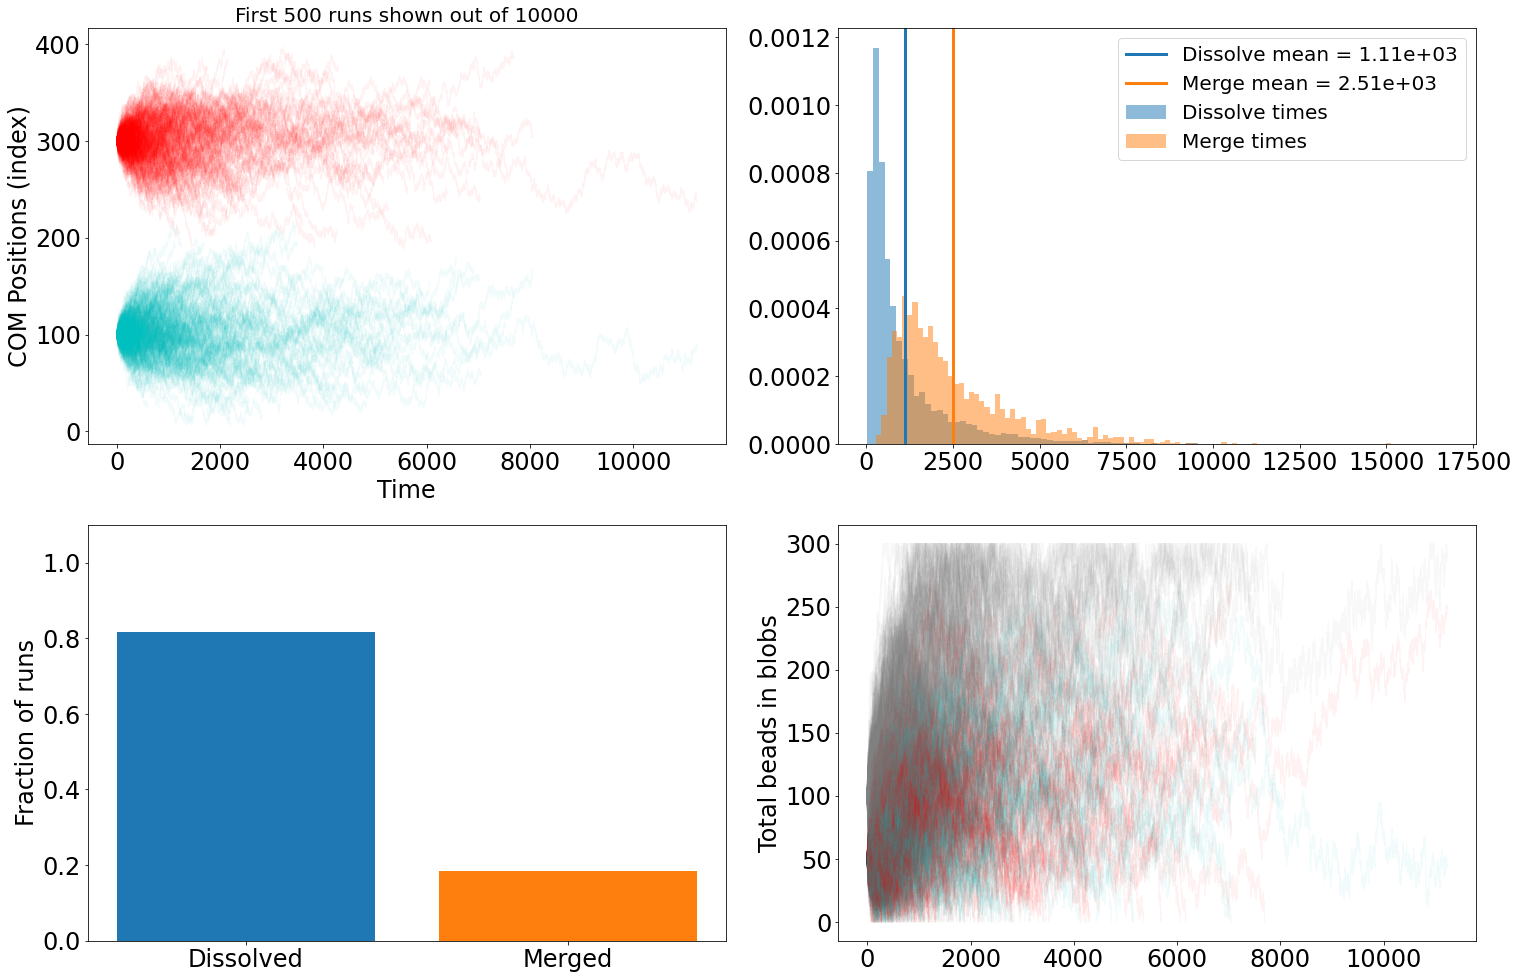

In [42]:
# A little name bashing
tmp_dict = g2_k101_dict
tmp_dst = tmp_dict['dissolve_times']
tmp_mt = tmp_dict['merge_times']

fig, axarr = plt.subplots(2, 2, figsize=(21, 14))
n_graph_runs = 500
#avg_t_com_arr, avg_com_arr = aa.find_avg_val_arr(tmp_dict['time'], tmp_dict['com'], n_timesteps=1000)
#avg_t_size_arr, avg_size_arr = aa.find_avg_val_arr(tmp_dict['time'], tmp_dict['size'], n_timesteps=1000)
cyc = cycler(color=['c','r'])
axarr[0,0].set_prop_cycle(cyc)
axarr[1,1].set_prop_cycle(cyc)
for time_arr, state_arr, com_arr, size_arr in zip(tmp_dict['time'][:n_graph_runs],
                                                  tmp_dict['state'][:n_graph_runs],
                                                  tmp_dict['coms'][:n_graph_runs],
                                                  tmp_dict['sizes'][:n_graph_runs]):

    _ = axarr[0,0].plot(time_arr, com_arr, alpha=.05, lw=1)
   # _ = axarr[0,0].plot(time_arr, com_arr[:, 1],
                         #color='orange', alpha=.05, lw=1)
#    _ = axarr[1][0].plot(time_arr, com_arr, color='k', alpha=.05, lw=1)
    _ = axarr[1][1].plot(time_arr, size_arr, alpha=.05, lw=1)
    _ = axarr[1][1].plot(time_arr, size_arr.sum(axis=-1), color='gray', alpha=.05, lw=1)
#_ = axarr[1][1].plot(avg_t_size_arr, avg_size_arr, color='r')
    
    
# Simulation plotting
_ = axarr[0, 1].hist(tmp_dst, density=True, bins=100,
                     label='Dissolve times',alpha=.5)
_ = axarr[0, 1].axvline(np.mean(tmp_dst), color='tab:blue',
                        label=f'Dissolve mean = {np.mean(tmp_dst):.3g}')
_ = axarr[0, 1].hist(tmp_mt, density=True, bins=100,
                     label='Merge times',alpha=.5)
_ = axarr[0, 1].axvline(np.mean(tmp_mt), color='tab:orange',
                        label=f'Merge mean = {np.mean(tmp_mt):.3g}')


_ = axarr[1,0].bar(range(2), [float(len(tmp_dst)/cycles), float(len(tmp_mt)/cycles)], color=['tab:blue', 'tab:orange'])
_ = axarr[1,0].set_xticks(range(2))
_ = axarr[1,0].set_xticklabels(['Dissolved', 'Merged'])

_ = axarr[1,0].set_ylabel("Fraction of runs")
_ = axarr[1,0].set_ylim(0,1.1)

# Labeling
_ = axarr[0, 0].set_title(
    f'First {n_graph_runs} runs shown out of {len(tmp_dict["time"])}')

_ = axarr[0, 0].set_xlabel('Time')
#_ = axarr[1, 1].set_xlabel('Time')
#_ = axarr[0, 1].set_xlabel('Life Time')

_ = axarr[0, 0].set_ylabel('COM Positions (index)')
#_ = axarr[1, 0].set_ylabel('COM Positions (index)')
#_ = axarr[0, 1].set_ylabel('Probability density')
_ = axarr[1, 1].set_ylabel('Total beads in blobs')

_ = axarr[0, 1].legend()
#_ = axarr[1].set_yscale('log')
fig.tight_layout()

In [44]:
cycles = 2000

g2_params = {
    'system_type': 'two_blobs',
    'n_beads' : 400, 
    'max_steps': -1,
    'init_state': [[75,125],[275,325]],
    'kinetics': {
        'func': 'const',
        'min_beads': 100,
        'kon': [[1.1,1.1],[1.1,1.1]],
        'koff': [[1.,1.],[1.,1.]]
    }
}

data_dict = { 'params': g2_params,
              'time': [],
              'state': [],
              'coms' : [],
              'merge_times' : [],
              'dissolve_times': [],
              'sizes' : [],
                  }



for i in tqdm(range(1, cycles+1)):
    time_arr, state_arr = aa.run_gill_gen(rng_seed=2*i, **g2_params)
    data_dict['time'] += [time_arr]
    data_dict['state'] += [state_arr]
    data_dict['sizes'] += [np.diff(state_arr, axis=-1).reshape(-1,2)]
    data_dict['coms'] += [state_arr.mean(axis=-1)]
    data_dict['merge_times'] += [time_arr[-1]] if state_arr[-1,0,1] == state_arr[-1,1,0] else []
    data_dict['dissolve_times'] += [time_arr[-1]] if state_arr[-1,0,0] == state_arr[-1,0,1] or state_arr[-1,1,0] == state_arr[-1,1,1] else []

g2_base_long_dict = deepcopy(data_dict)


  0%|          | 0/2000 [00:00<?, ?it/s]

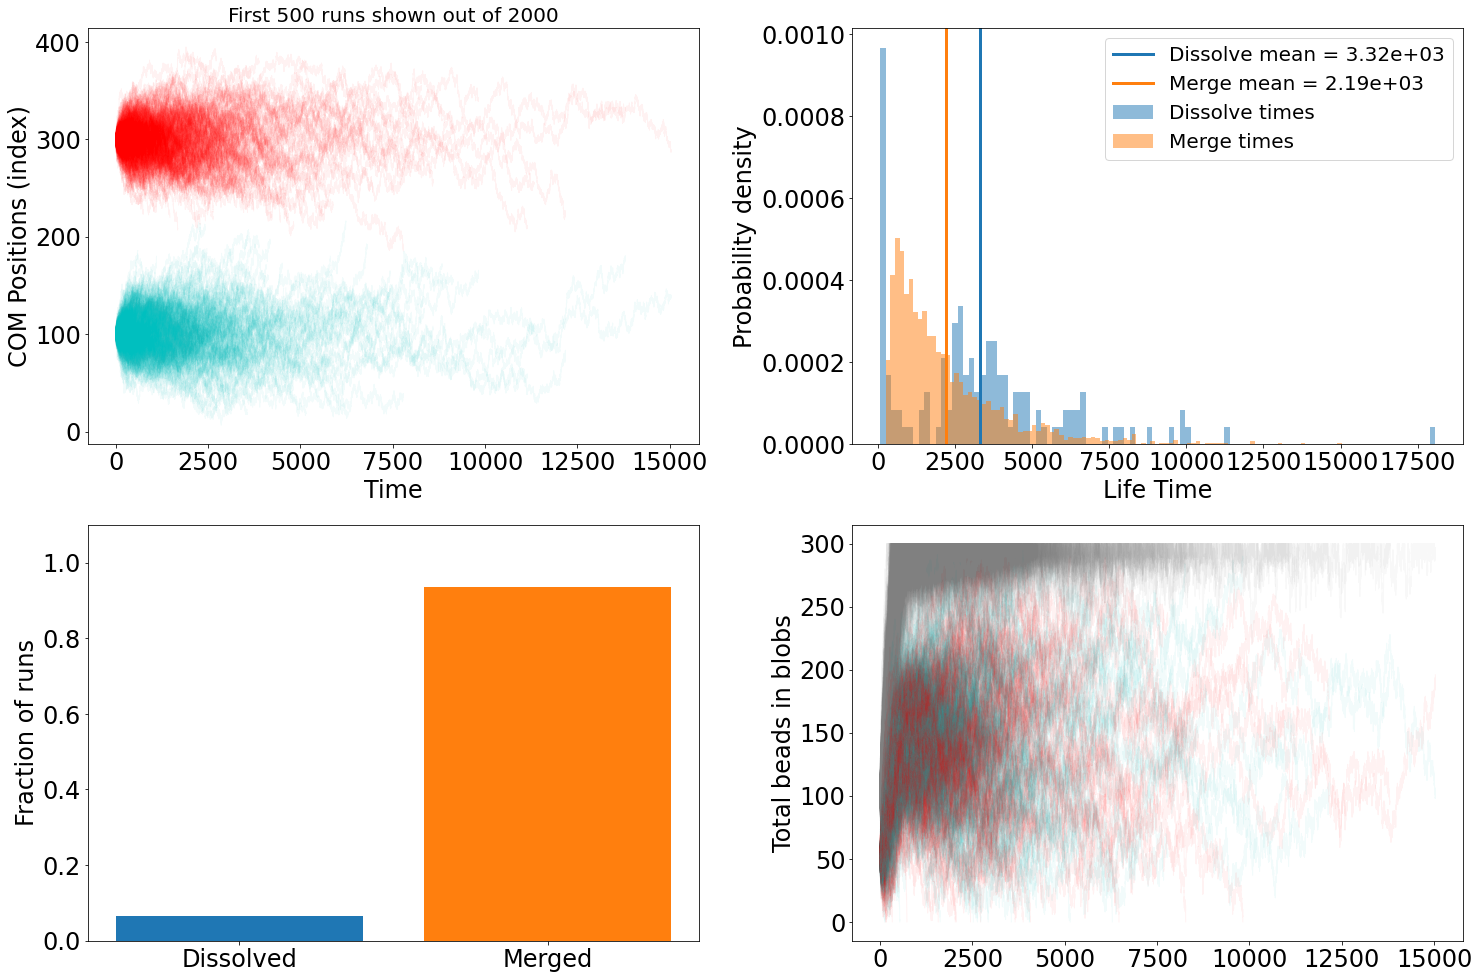

In [45]:
# A little name bashing
tmp_dict = g2_base_long_dict
tmp_dst = tmp_dict['dissolve_times']
tmp_mt = tmp_dict['merge_times']

fig, axarr = plt.subplots(2, 2, figsize=(21, 14))
n_graph_runs = 500
#avg_t_com_arr, avg_com_arr = aa.find_avg_val_arr(tmp_dict['time'], tmp_dict['com'], n_timesteps=1000)
#avg_t_size_arr, avg_size_arr = aa.find_avg_val_arr(tmp_dict['time'], tmp_dict['size'], n_timesteps=1000)
cyc = cycler(color=['c','r'])
axarr[0,0].set_prop_cycle(cyc)
axarr[1,1].set_prop_cycle(cyc)
for time_arr, state_arr, com_arr, size_arr in zip(tmp_dict['time'][:n_graph_runs],
                                                  tmp_dict['state'][:n_graph_runs],
                                                  tmp_dict['coms'][:n_graph_runs],
                                                  tmp_dict['sizes'][:n_graph_runs]):

    _ = axarr[0,0].plot(time_arr, com_arr, alpha=.05, lw=1)
   # _ = axarr[0,0].plot(time_arr, com_arr[:, 1],
                         #color='orange', alpha=.05, lw=1)
#    _ = axarr[1][0].plot(time_arr, com_arr, color='k', alpha=.05, lw=1)
    _ = axarr[1][1].plot(time_arr, size_arr, alpha=.05, lw=1)
    _ = axarr[1][1].plot(time_arr, size_arr.sum(axis=-1), color='gray', alpha=.05, lw=1)
#_ = axarr[1][1].plot(avg_t_size_arr, avg_size_arr, color='r')
    
    
# Simulation plotting
_ = axarr[0, 1].hist(tmp_dst, density=True, bins=100,
                     label='Dissolve times',alpha=.5)
_ = axarr[0, 1].axvline(np.mean(tmp_dst), color='tab:blue',
                        label=f'Dissolve mean = {np.mean(tmp_dst):.3g}')
_ = axarr[0, 1].hist(tmp_mt, density=True, bins=100,
                     label='Merge times',alpha=.5)
_ = axarr[0, 1].axvline(np.mean(tmp_mt), color='tab:orange',
                        label=f'Merge mean = {np.mean(tmp_mt):.3g}')


_ = axarr[1,0].bar(range(2), [float(len(tmp_dst)/cycles), float(len(tmp_mt)/cycles)], color=['tab:blue', 'tab:orange'])
_ = axarr[1,0].set_xticks(range(2))
_ = axarr[1,0].set_xticklabels(['Dissolved', 'Merged'])

_ = axarr[1,0].set_ylim(0,1.1)

# Labeling
_ = axarr[0, 0].set_title(
    f'First {n_graph_runs} runs shown out of {len(tmp_dict["time"])}')

_ = axarr[0, 0].set_xlabel('Time')
_ = axarr[0, 1].set_xlabel('Life Time')

_ = axarr[0, 0].set_ylabel('COM Positions (index)')
_ = axarr[1, 0].set_ylabel("Fraction of runs")
_ = axarr[0, 1].set_ylabel('Probability density')
_ = axarr[1, 1].set_ylabel('Total beads in blobs')

_ = axarr[0, 1].legend()
#_ = axarr[1].set_yscale('log')
fig.tight_layout()

# Parameter scans

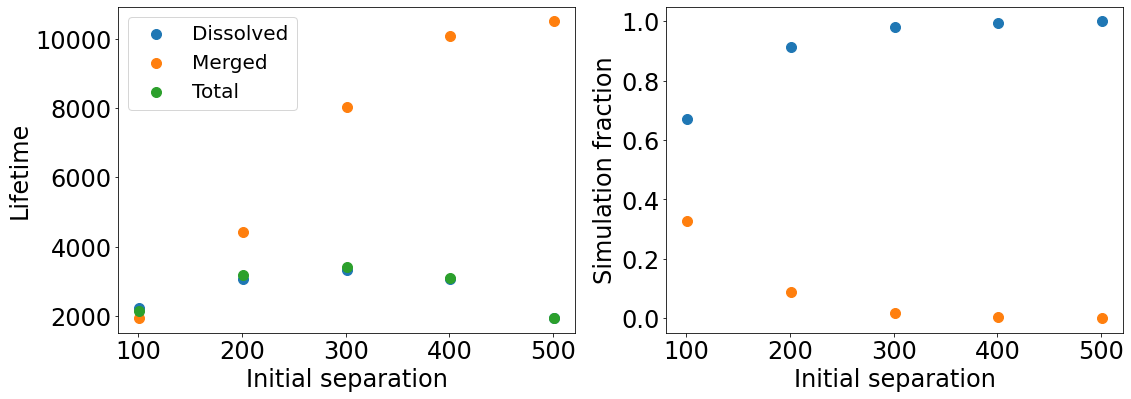

In [21]:
data_path = (ceph_path /"22-02-23_TB700_scan5.1_sep100-500/simulations/")
ss_ind = 0
end_ind = 4000
start_bead = 0
end_bead = -1

mean_lt = []
merge_mean = []
dis_mean = []
sep = []
merge_frac = []
dis_frac = []
fig, axarr = plt.subplots(1,2, figsize=(18,6))
for h5_file in data_path.glob('*/*.h5'):
    with h5py.File(h5_file, 'r+') as h5_data:
        params = yaml.safe_load(h5_data.attrs['params'])
        sep += [params['init_state'][1][0] - params['init_state'][0][1]]
        merge_mean += [h5_data.attrs['merge_mean_lifetime']]
        dis_mean += [h5_data.attrs['dissolve_mean_lifetime']]
        mean_lt += [h5_data.attrs['mean_lifetime']]
        merge_frac += [h5_data.attrs['merge_frac']]
        dis_frac += [h5_data.attrs['dissolve_frac']]

_ = axarr[0].scatter(sep, dis_mean, label='Dissolved')
_ = axarr[0].scatter(sep, merge_mean, label='Merged')
_ = axarr[0].scatter(sep, mean_lt, label='Total')

_ = axarr[1].scatter(sep, dis_frac)
_ = axarr[1].scatter(sep, merge_frac)

_ = axarr[0].set_xlabel('Initial separation')
_ = axarr[1].set_xlabel('Initial separation')

_ = axarr[0].set_ylabel('Lifetime')
_ = axarr[1].set_ylabel('Simulation fraction')

_ = axarr[0].legend()

/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-02-24_TB700_scan10.1_sep200_size100_minBeads50-200/simulations/mBds200/mBds200.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-02-24_TB700_scan10.1_sep200_size100_minBeads50-200/simulations/mBds400/mBds400.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-02-24_TB700_scan10.1_sep200_size100_minBeads50-200/simulations/mBds50/mBds50.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-02-24_TB700_scan10.1_sep200_size100_minBeads50-200/simulations/mBds250/mBds250.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-02-24_TB700_scan10.1_sep200_size100_minBeads50-200/simulations/mBds150/mBds150.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-02-24_TB700_scan10.1_sep200_size100_minBeads50-200/simulations/mBds450/mBds450.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-02-24_TB700_scan10.1_sep200_size100_minBeads50-200/simulations/mBds300/mBds300.h5
/mnt/home/alamson/ceph/DATA/Chromati

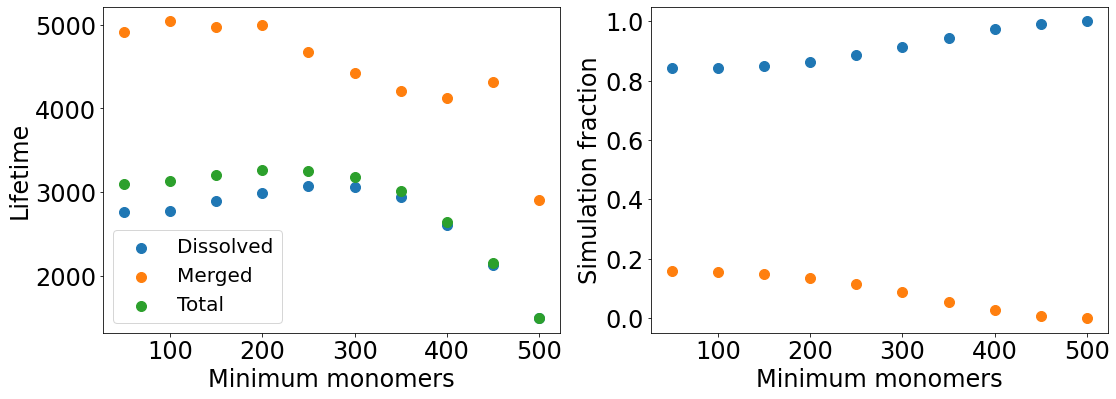

In [29]:
data_path = (ceph_path /"22-02-24_TB700_scan10.1_sep200_size100_minBeads50-200/simulations")
ss_ind = 0
end_ind = 4000
start_bead = 0
end_bead = -1

mean_lt = []
merge_mean = []
dis_mean = []
min_beads = []
merge_frac = []
dis_frac = []
fig, axarr = plt.subplots(1,2, figsize=(18,6))
for h5_file in data_path.glob('*/*.h5'):
    print(h5_file)
    with h5py.File(h5_file, 'r+') as h5_data:
        params = yaml.safe_load(h5_data.attrs['params'])
        min_beads += [params['kinetics']['min_beads']]
        merge_mean += [h5_data.attrs['merge_mean_lifetime']]
        dis_mean += [h5_data.attrs['dissolve_mean_lifetime']]
        mean_lt += [h5_data.attrs['mean_lifetime']]
        merge_frac += [h5_data.attrs['merge_frac']]
        dis_frac += [h5_data.attrs['dissolve_frac']]

_ = axarr[0].scatter(min_beads, dis_mean, label='Dissolved')
_ = axarr[0].scatter(min_beads, merge_mean, label='Merged')
_ = axarr[0].scatter(min_beads, mean_lt, label='Total')

_ = axarr[1].scatter(min_beads, dis_frac)
_ = axarr[1].scatter(min_beads, merge_frac)

_ = axarr[0].set_xlabel('Minimum monomers')
_ = axarr[1].set_xlabel('Minimum monomers')

_ = axarr[0].set_ylabel('Lifetime')
_ = axarr[1].set_ylabel('Simulation fraction')

_ = axarr[0].legend()

/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-02-24_TB700_scan7.1_sep200_size50-200/simulations/e0L75_e1R624/e0L75_e1R624.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-02-24_TB700_scan7.1_sep200_size50-200/simulations/e0L125_e1R574/e0L125_e1R574.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-02-24_TB700_scan7.1_sep200_size50-200/simulations/e0L200_e1R499/e0L200_e1R499.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-02-24_TB700_scan7.1_sep200_size50-200/simulations/e0L100_e1R599/e0L100_e1R599.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-02-24_TB700_scan7.1_sep200_size50-200/simulations/e0L50_e1R649/e0L50_e1R649.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-02-24_TB700_scan7.1_sep200_size50-200/simulations/e0L150_e1R549/e0L150_e1R549.h5
/mnt/home/alamson/ceph/DATA/Chromatin/MC_condensates/22-02-24_TB700_scan7.1_sep200_size50-200/simulations/e0L175_e1R524/e0L175_e1R524.h5


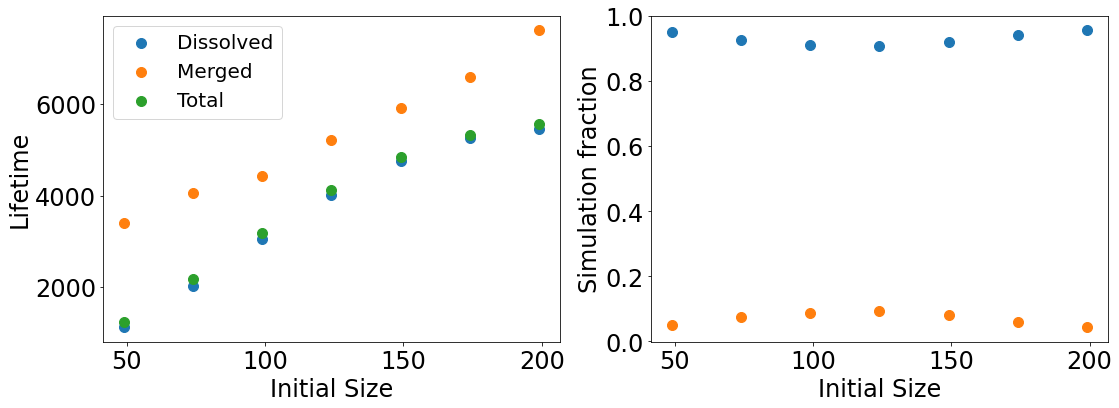

In [30]:
data_path = (ceph_path /"22-02-24_TB700_scan7.1_sep200_size50-200/simulations")
ss_ind = 0
end_ind = 4000
start_bead = 0
end_bead = -1

mean_lt = []
merge_mean = []
dis_mean = []
init_size = []
merge_frac = []
dis_frac = []
fig, axarr = plt.subplots(1,2, figsize=(18,6))
for h5_file in data_path.glob('*/*.h5'):
    print(h5_file)
    with h5py.File(h5_file, 'r+') as h5_data:
        params = yaml.safe_load(h5_data.attrs['params'])
        init_size += [params['init_state'][1][1] - params['init_state'][1][0]]
        merge_mean += [h5_data.attrs['merge_mean_lifetime']]
        dis_mean += [h5_data.attrs['dissolve_mean_lifetime']]
        mean_lt += [h5_data.attrs['mean_lifetime']]
        merge_frac += [h5_data.attrs['merge_frac']]
        dis_frac += [h5_data.attrs['dissolve_frac']]

_ = axarr[0].scatter(init_size, dis_mean, label='Dissolved')
_ = axarr[0].scatter(init_size, merge_mean, label='Merged')
_ = axarr[0].scatter(init_size, mean_lt, label='Total')

_ = axarr[1].scatter(init_size, dis_frac)
_ = axarr[1].scatter(init_size, merge_frac)

_ = axarr[0].set_xlabel('Initial Size')
_ = axarr[1].set_xlabel('Initial Size')

_ = axarr[0].set_ylabel('Lifetime')
_ = axarr[1].set_ylabel('Simulation fraction')

_ = axarr[0].legend()

# Weird tests

In [72]:
print(Path.cwd().stem)

notebooks


In [58]:
try:
    h5_data = h5py.File(ceph_path / 'test.h5', 'w')
    for i, time in enumerate(data_dict['time']):
        new_grp = h5_data.create_group(f'run_{i}')
        _ = new_grp.create_dataset('times', data=data_dict['time'][i]) 
        _ = new_grp.create_dataset('states', data=data_dict['state'][i]) 
        _ = new_grp.create_dataset('sizes', data=data_dict['sizes'][i]) 
        _ = new_grp.create_dataset('coms', data=data_dict['coms'][i])
    _ = h5_data.create_dataset('merge_times', data=data_dict['merge_times'])
    _ = h5_data.create_dataset('dissolve_times', data=data_dict['dissolve_times'])
except:
    raise
finally:
    h5_data.close()

20
[1.00000000e+00 2.00000000e+00 3.00000000e+00 2.74860484e+03
 1.91150851e+03 1.01777002e+04 8.56952916e+02 5.17282264e+03
 7.91733271e+02 2.21718736e+03 2.92446330e+03 3.53469346e+03
 3.92043678e+03 8.21240395e+02 5.16783163e+03 1.82861078e+03
 1.72561894e+03 4.32648310e+03 2.08131049e+03 6.68479281e+03
 4.99932554e+03 1.43105902e+03 7.23840908e+02]


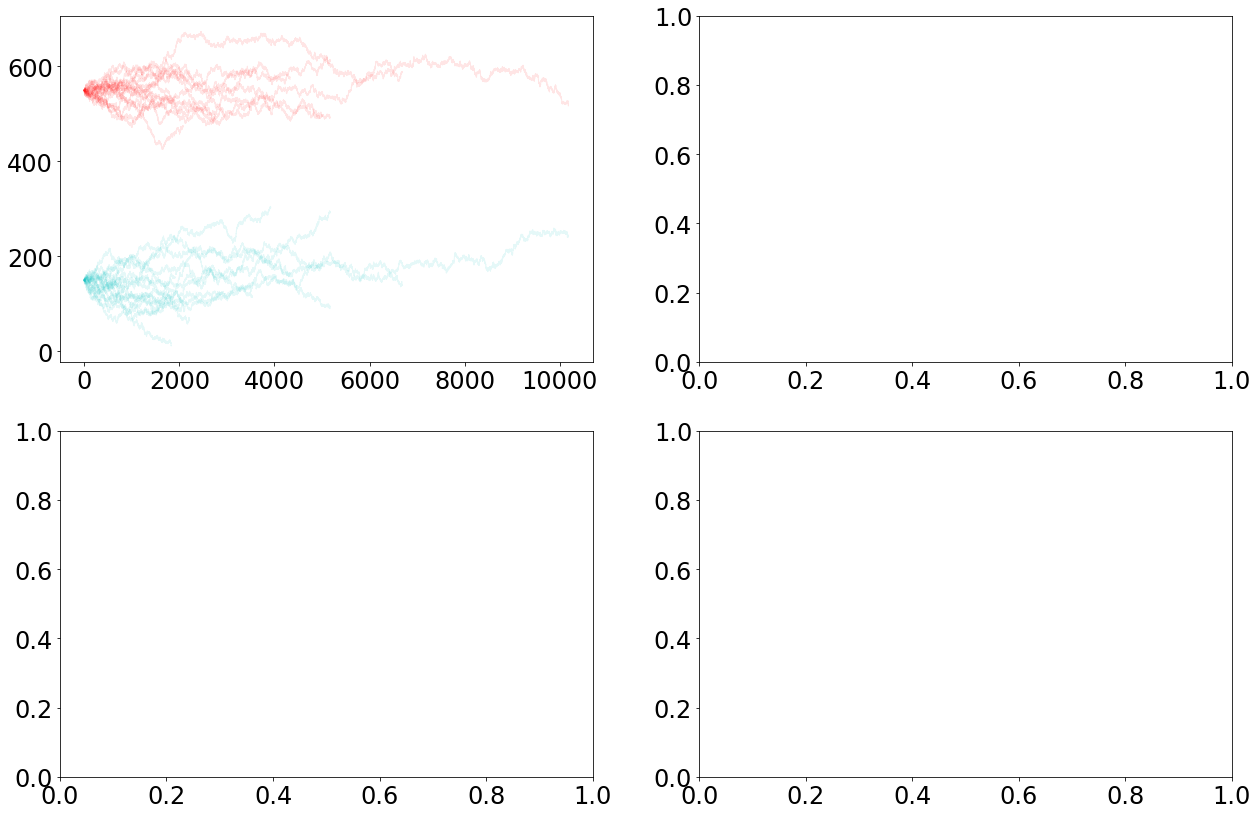

In [84]:
h5_data = h5py.File(ceph_path / '22-02-23_TB700_scan5.1_sep100-500/simulations/e0L100_e0R199_e1L500_e1R599/gill_data.h5', 'r')
fig, axarr = plt.subplots(2, 2, figsize=(21, 14))
cyc = cycler(color=['c','r'])
axarr[0,0].set_prop_cycle(cyc)
axarr[1,1].set_prop_cycle(cyc)
for grp in h5_data.values():
    if not isinstance(grp,h5py.Group):
        continue
    _ = axarr[0,0].plot(grp['times'], grp['coms'], alpha=.1, lw=1)


In [85]:
h5_data.close()

In [40]:
lst = [1,2,3]
lst += [None]

In [41]:
print(lst)

[1, 2, 3, None]


In [130]:
test_lambda_dict = [
    lambda x: x+1,
    lambda x: x-1,
]

print(test_lambda_dict)

[<function <lambda> at 0x7ff7f02b1f70>, <function <lambda> at 0x7ff7f02b1e50>]


In [134]:
print(test_lambda_dict)
a = test_lambda_dict[0](1)
print(a)
print(test_lambda_dict)

[<function <lambda> at 0x7ff7f02b1f70>, <function <lambda> at 0x7ff7f02b1e50>]
2
[<function <lambda> at 0x7ff7f02b1f70>, <function <lambda> at 0x7ff7f02b1e50>]


In [136]:
TWO_PART_CONST_UPDATE_LST = [
    lambda state: [[state[-1][0]-1, state[-1][1]]],
    lambda state: [[state[-1][0]+1, state[-1][1]]],
    lambda state: [[state[-1][0], state[-1][1]-1]],
    lambda state: [[state[-1][0], state[-1][1]+1]],
]

In [142]:
new_state = TWO_PART_CONST_UPDATE_LST[2]([[1,5]])
print(new_state)

[[1, 4]]
